In [1]:
import pandas as pd
import os
import sys

project_root = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))
sys.path.append(project_root)

from utils.cmod5n import cmod5n_forward, cmod5n_inverse
from utils.functions import *


import xarray as xr
from glob import glob


from sklearn.cluster import KMeans
from sklearn.metrics import root_mean_squared_error

In [ ]:
df1 = pd.read_parquet("../processed_data/wv1_complete.parquet")
df2 = pd.read_parquet("../processed_data/wv2_complete.parquet")

df1 = create_phi_bins_columns(df1, 'phi_nominal_median', 1)
df2 = create_phi_bins_columns(df2, 'phi_nominal_median', 1)

df1r = pd.read_parquet("../results/wv1_results_updated.parquet")
df2r = pd.read_parquet("../results/wv2_results_updated.parquet")

df1w = pd.read_parquet("../results/wv1_wind_results.parquet")
df2w = pd.read_parquet("../results/wv2_wind_results.parquet")

df1r["renamed_filename"] = df1r.sar_filepath.apply(lambda x: x.split("/")[-1])
df2r["renamed_filename"] = df2r.sar_filepath.apply(lambda x: x.split("/")[-1])

df1w["renamed_filename"] = df1w.sar_filepath.apply(lambda x: x.split("/")[-1])
df2w["renamed_filename"] = df2w.sar_filepath.apply(lambda x: x.split("/")[-1])

idxmax = df1w.k_values_wind.apply(lambda x: len(x)).argmax()
max_len = df1w.k_values_wind.apply(lambda x: len(x)).max()

df1r = pad_arrays_to_max_length(df1r, 'radial_psd', max_len)
df2r = pad_arrays_to_max_length(df2r, 'radial_psd', max_len)

df1w = pad_arrays_to_max_length(df1w, 'radial_wind_psd', max_len)
df2w = pad_arrays_to_max_length(df2w, 'radial_wind_psd', max_len)

df1w = pad_arrays_to_max_length(df1w, 'radial_residual_psd', max_len)
df2w = pad_arrays_to_max_length(df2w, 'radial_residual_psd', max_len)

df1w = pad_arrays_to_max_length(df1w, 'radial_wind_field_residual_psd', max_len)
df2w = pad_arrays_to_max_length(df2w, 'radial_wind_field_residual_psd', max_len)

df1 = pd.merge(left=df1, right=df1r, on='renamed_filename')
df1 = pd.merge(left=df1, right=df1w, on='renamed_filename')

df2 = pd.merge(left=df2, right=df2r, on='renamed_filename')
df2 = pd.merge(left=df2, right=df2w, on='renamed_filename')

In [ ]:
# df1['residual_nrcs_rmse'] = np.sqrt( (df1['sigma_cmod_median'] - df1['sigma_sar_median'])**2)
# df2['residual_nrcs_rmse'] = np.sqrt( (df2['sigma_cmod_median'] - df2['sigma_sar_median'])**2)

df1 = df1.dropna(subset=['residual_median'])
df2 = df2.dropna(subset=['residual_median'])

df1 = create_phi_bins_columns(df1, 'phi_nominal', 30)
df2 = create_phi_bins_columns(df2, 'phi_nominal', 30)

df1 = df1[df1.class_1 != "SI"]
df2 = df2[df2.class_1 != "SI"]

df1 = df1[df1.class_2 != "SI"]
df2 = df2[df2.class_2 != "SI"]

df1 = df1[df1.class_3 != "SI"]
df2 = df2[df2.class_3 != "SI"]

In [ ]:
mad1 = np.median(np.abs(df1.residual_median - np.median(df1.residual_median)))
ts1 = np.median(df1.residual_median) # + 2 * mad1

mad2 = np.median(np.abs(df2.residual_median - np.median(df2.residual_median)))
ts2 = np.median(df2.residual_median) # + 2 * mad2

df1['nrcs_retrieval'] = df1['residual_median'].apply(lambda x: bad_or_good_retrieval(x, ts1))
df2['nrcs_retrieval'] = df2['residual_median'].apply(lambda x: bad_or_good_retrieval(x, ts2))


In [ ]:
k_values = get_k_values(df1, "k_values")
k_values = k_values/20

In [ ]:
d1 = plot_retrieval_quality_per_q(ts1, df1)

In [ ]:
d2 = plot_retrieval_quality_per_q(ts2, df2)

In [ ]:
df1['mean_b2'] = df1['b2'].apply(lambda x: get_mean(x))
df2['mean_b2'] = df2['b2'].apply(lambda x: get_mean(x))

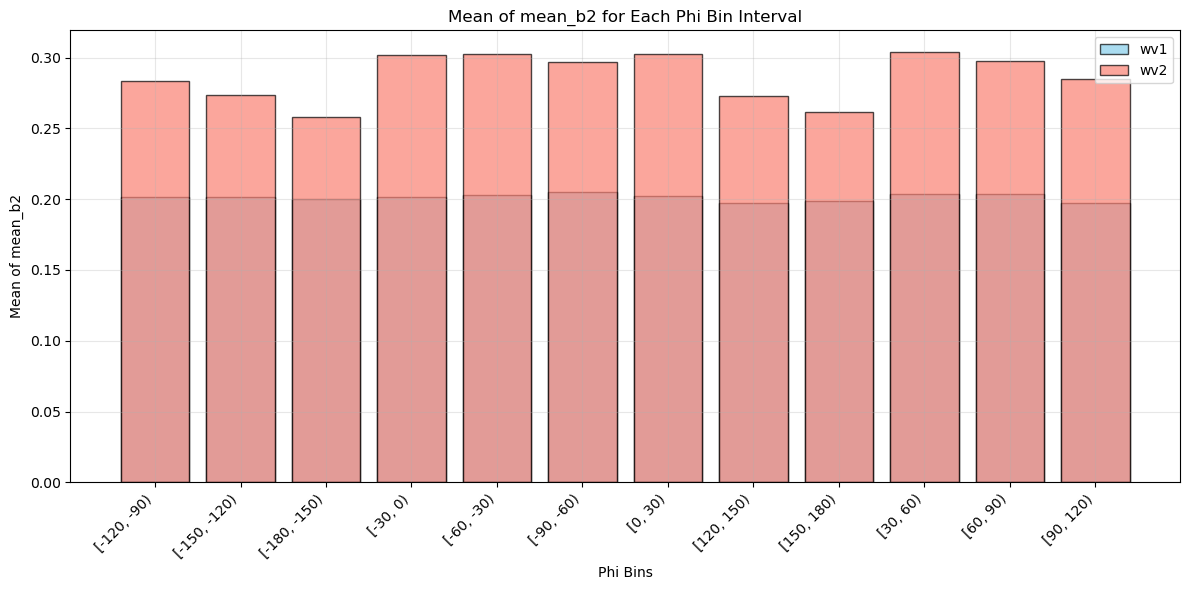

In [ ]:
# Group by phi_bins and calculate the mean of mean_b2 for each bin
grouped_means1 = df1.groupby('phi_bins')['mean_b2'].mean()
grouped_means2 = df2.groupby('phi_bins')['mean_b2'].mean()

# Create the plot
plt.figure(figsize=(12, 6))
plt.bar(range(len(grouped_means1)), grouped_means1.values, alpha=0.7, color='skyblue', edgecolor='black',
        label="wv1")
plt.bar(range(len(grouped_means2)), grouped_means2.values, alpha=0.7, color='salmon', edgecolor='black',
        label="wv2")
# Set x-axis labels to show the phi bin intervals
plt.xticks(range(len(grouped_means1)), grouped_means1.index, rotation=45, ha='right')
plt.xlabel('Phi Bins')
plt.ylabel('Mean of mean_b2')
plt.title('Mean of mean_b2 for Each Phi Bin Interval')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# # Print the results as well
# print("Mean of mean_b2 for each phi bin for WV1:")
# for bin_interval, mean_value in grouped_means1.items():
#     print(f"{bin_interval}: {mean_value:.6f}")

# print("\nMean of mean_b2 for each phi bin for WV2:")
# for bin_interval, mean_value in grouped_means2.items():
#     print(f"{bin_interval}: {mean_value:.6f}")


In [ ]:
grouped_means_psd1 = df1.groupby('phi_bins')['radial_wind_psd_padded'].mean()
grouped_means_psd2 = df2.groupby('phi_bins')['radial_wind_psd_padded'].mean()

grouped_means_residual1 = df1.groupby('phi_bins')['radial_residual_psd_padded'].mean()
grouped_means_residual2 = df2.groupby('phi_bins')['radial_residual_psd_padded'].mean()

In [ ]:
grouped_means_psd1 = df1.groupby('phi_bins')['radial_wind_psd_padded'].mean()
grouped_means_psd2 = df2.groupby('phi_bins')['radial_wind_psd_padded'].mean()

grouped_means_residual1 = df1.groupby('phi_bins')['radial_residual_psd_padded'].mean()
grouped_means_residual2 = df2.groupby('phi_bins')['radial_residual_psd_padded'].mean()

In [ ]:
epsilon = 1e-10  # or any small number you prefer
psd_ratio = (grouped_means_psd1 + epsilon) / (grouped_means_psd2 + epsilon)

residual_psd_ratio = (grouped_means_residual1 + epsilon) / (grouped_means_residual2 + epsilon)


In [ ]:
df1['mean_b1'] = df1['b1'].apply(lambda x: get_mean(x))
df2['mean_b1'] = df2['b1'].apply(lambda x: get_mean(x))

df1['mean_b0'] = df1['b0'].apply(lambda x: get_mean(x))
df2['mean_b0'] = df2['b0'].apply(lambda x: get_mean(x))

In [ ]:
b0_mean_ratio = df1.groupby('phi_bins')['mean_b0'].mean() / df2.groupby('phi_bins')['mean_b0'].mean()
b1_mean_ratio = df1.groupby('phi_bins')['mean_b1'].mean() / df2.groupby('phi_bins')['mean_b1'].mean()
b2_mean_ratio = df1.groupby('phi_bins')['mean_b2'].mean() / df2.groupby('phi_bins')['mean_b2'].mean()


b0_correlations, wavelengths = analyze_b_parameter_vs_psd(b0_mean_ratio, psd_ratio, k_values, 'B0');
b1_correlations, wavelengths = analyze_b_parameter_vs_psd(b1_mean_ratio, psd_ratio, k_values, 'B1');
b2_correlations, wavelengths = analyze_b_parameter_vs_psd(b2_mean_ratio, psd_ratio, k_values, 'B2');


In [ ]:
b0_mean_wv1 = df1.groupby('phi_bins')['mean_b0'].mean()
b1_mean_wv1 = df1.groupby('phi_bins')['mean_b1'].mean()
b2_mean_wv1 = df1.groupby('phi_bins')['mean_b2'].mean()

b0_mean_wv2 = df2.groupby('phi_bins')['mean_b0'].mean()
b1_mean_wv2 = df2.groupby('phi_bins')['mean_b1'].mean()
b2_mean_wv2 = df2.groupby('phi_bins')['mean_b2'].mean()


In [ ]:
b0_corr, b0_lo, b0_hi, wavelengths = analyze_b_parameter_vs_psd_bootstrap(
    b0_mean_wv2, grouped_means_psd2, k_values, 'B0', n_boot=1000, plot=False)

b1_corr, b1_lo, b1_hi, wavelengths = analyze_b_parameter_vs_psd_bootstrap(
    b1_mean_wv2, grouped_means_psd2, k_values, 'B1', n_boot=1000, plot=False)

b2_corr, b2_lo, b2_hi, wavelengths = analyze_b_parameter_vs_psd_bootstrap(
    b2_mean_wv2, grouped_means_psd2, k_values, 'B2', n_boot=1000, plot=False)

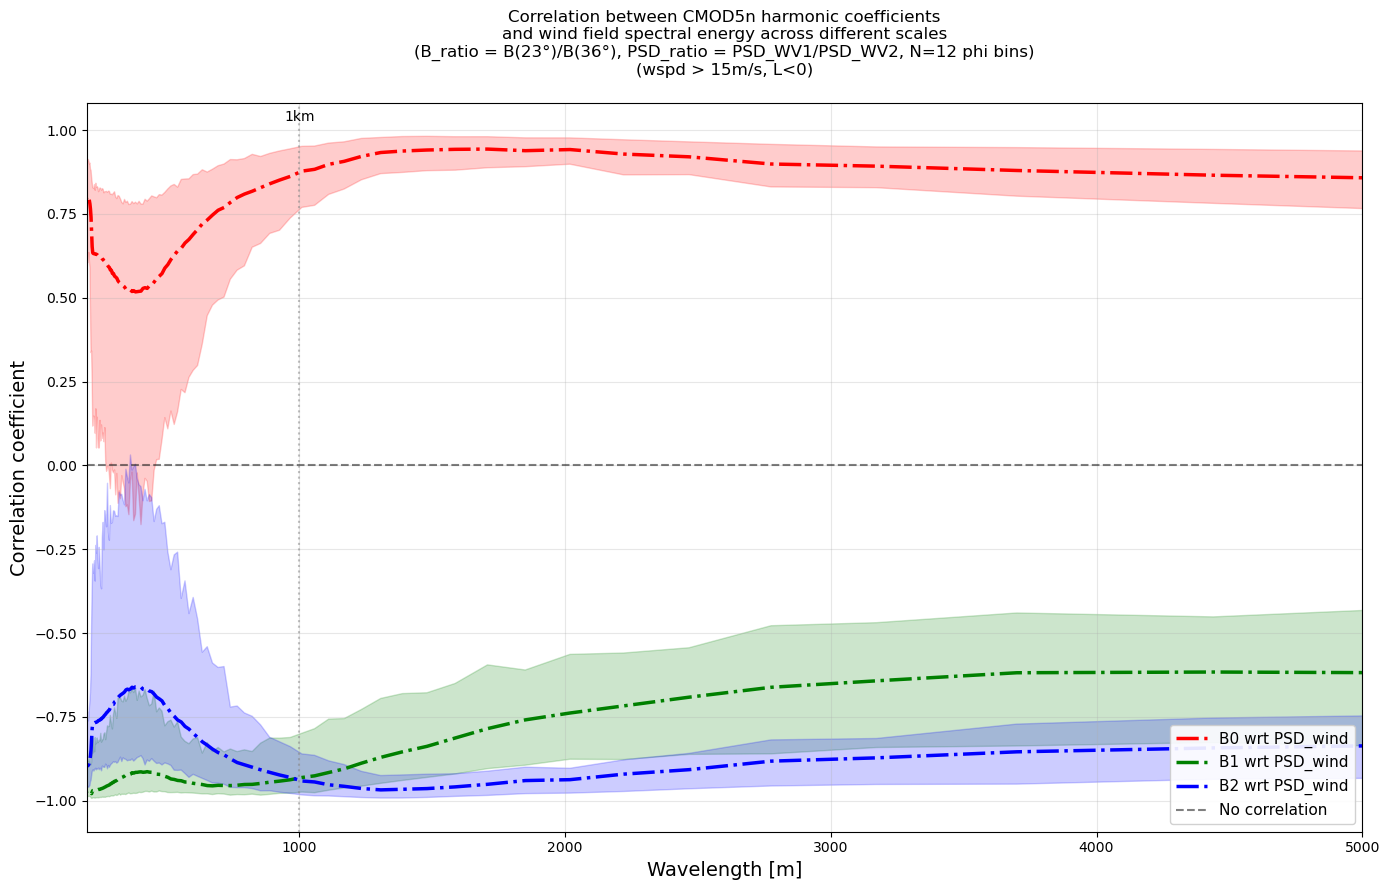

In [ ]:
plot_b_coeff_correlations(
    wavelengths,
    b0_corr, b0_lo, b0_hi,
    b1_corr, b1_lo, b1_hi,
    b2_corr, b2_lo, b2_hi,
    use_semilogx=False
)

In [ ]:
print(len(df1), len(df2))

df1 = df1[~df1['radial_residual_psd_padded'].apply(lambda x: np.isnan(x).any())]
df2 = df2[~df2['radial_residual_psd_padded'].apply(lambda x: np.isnan(x).any())]

print(len(df1), len(df2))

df1 = df1[~df1['radial_wind_psd_padded'].apply(lambda x: np.isnan(x).any())]
df2 = df2[~df2['radial_wind_psd_padded'].apply(lambda x: np.isnan(x).any())]

print(len(df1), len(df2))

df1['derivative_radial_wind_psd'] = df1['radial_wind_psd_padded'].apply(lambda x: np.gradient(x, k_values))
df1['derivative_radial_residual_psd'] = df1['radial_residual_psd_padded'].apply(lambda x: np.gradient(x, k_values))

df2['derivative_radial_wind_psd'] = df2['radial_wind_psd_padded'].apply(lambda x: np.gradient(x, k_values))
df2['derivative_radial_residual_psd'] = df2['radial_residual_psd_padded'].apply(lambda x: np.gradient(x, k_values))

df1 = df1[~df1['derivative_radial_wind_psd'].apply(lambda x: np.isnan(x).any())]
df2 = df2[~df2['derivative_radial_wind_psd'].apply(lambda x: np.isnan(x).any())]

print(len(df1), len(df2))

df1 = df1[~df1['derivative_radial_residual_psd'].apply(lambda x: np.isnan(x).any())]
df2 = df2[~df2['derivative_radial_residual_psd'].apply(lambda x: np.isnan(x).any())]

print(len(df1), len(df2))

34494 34896
34494 34896
34494 34896
34494 34896
34494 34896


In [ ]:
plot_radial_psd_diff_combined(df1, wavelengths, col='radial_residual_psd_padded', 
                              d=d1, q=ts1, linear_yaxis=True, 
                              plot_conf_interval=True, save_image=True)

c:\Users\trouv\code\msc-thesis\utils\functions.py:2297: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=8)


q0-wv1-radial_residual_psd_padded


c:\Users\trouv\code\msc-thesis\utils\functions.py:2297: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=8)


KeyboardInterrupt: 

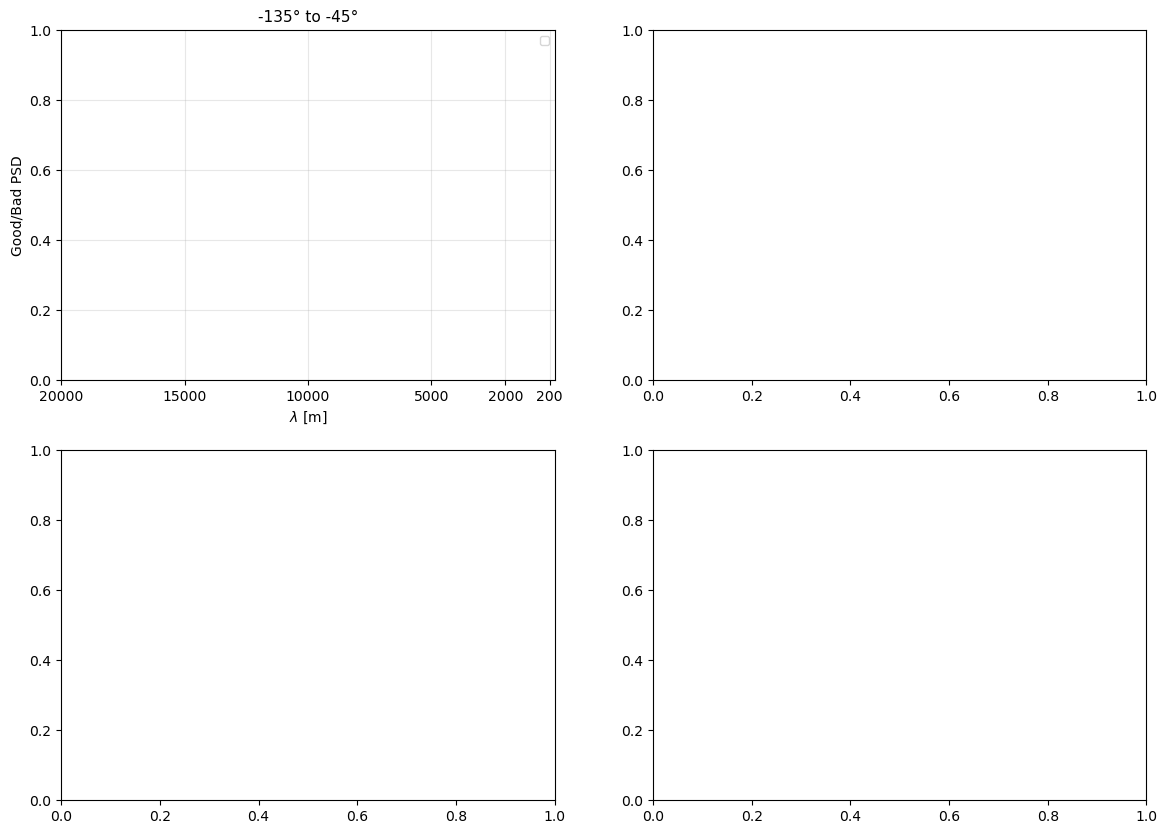

In [ ]:
plot_radial_psd_diff_combined(df2, wavelengths, col='radial_residual_psd_padded', d=d2, q=ts2, 
                              linear_yaxis=True, plot_conf_interval=True, save_image=True)

In [ ]:
plot_radial_psd_diff_combined(df1, wavelengths, col='radial_wind_psd_padded', d=d1, q=ts1, 
                              linear_yaxis=True, plot_conf_interval=True, save_image=True)

c:\Users\trouv\code\msc-thesis\utils\functions.py:2243: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_good['phi_mid'] = df_good['phi_bins'].astype(str).map(phi_mid)
c:\Users\trouv\code\msc-thesis\utils\functions.py:2244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bad['phi_mid'] = df_bad['phi_bins'].astype(str).map(phi_mid)
c:\Users\trouv\code\msc-thesis\utils\functions.py:2297: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ig

q0-wv1-radial_wind_psd_padded


In [ ]:
plot_radial_psd_diff_combined(df2, wavelengths, col='radial_wind_psd_padded', d=d2, q=ts2, 
                              linear_yaxis=True, plot_conf_interval=True, save_image=True)

c:\Users\trouv\code\msc-thesis\utils\functions.py:2243: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_good['phi_mid'] = df_good['phi_bins'].astype(str).map(phi_mid)
c:\Users\trouv\code\msc-thesis\utils\functions.py:2244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bad['phi_mid'] = df_bad['phi_bins'].astype(str).map(phi_mid)
c:\Users\trouv\code\msc-thesis\utils\functions.py:2297: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ig

q0-wv2-radial_wind_psd_padded


In [ ]:
plot_radial_psd_diff_combined(df1, wavelengths, col='derivative_radial_wind_psd', d=d1,q=ts1, yrange=[-5, 5],
                              linear_yaxis=True, plot_conf_interval=True, save_image=True)

c:\Users\trouv\code\msc-thesis\utils\functions.py:2243: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_good['phi_mid'] = df_good['phi_bins'].astype(str).map(phi_mid)
c:\Users\trouv\code\msc-thesis\utils\functions.py:2244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bad['phi_mid'] = df_bad['phi_bins'].astype(str).map(phi_mid)
c:\Users\trouv\code\msc-thesis\utils\functions.py:2297: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ig

q0-wv1-derivative_radial_wind_psd


In [ ]:
plot_radial_psd_diff_combined(df1, wavelengths, col='derivative_radial_residual_psd', d=d1, q=ts1, yrange=[-5, 5],
                              linear_yaxis=True, plot_conf_interval=True, save_image=True)

c:\Users\trouv\code\msc-thesis\utils\functions.py:2243: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_good['phi_mid'] = df_good['phi_bins'].astype(str).map(phi_mid)
c:\Users\trouv\code\msc-thesis\utils\functions.py:2244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bad['phi_mid'] = df_bad['phi_bins'].astype(str).map(phi_mid)
c:\Users\trouv\code\msc-thesis\utils\functions.py:2297: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ig

q0-wv1-derivative_radial_residual_psd


In [ ]:
plot_radial_psd_diff_combined(df2, wavelengths, col='derivative_radial_wind_psd', d=d2,q=ts2, yrange=[-5, 5],
                              linear_yaxis=True, plot_conf_interval=True, save_image=True)

c:\Users\trouv\code\msc-thesis\utils\functions.py:2243: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_good['phi_mid'] = df_good['phi_bins'].astype(str).map(phi_mid)
c:\Users\trouv\code\msc-thesis\utils\functions.py:2244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bad['phi_mid'] = df_bad['phi_bins'].astype(str).map(phi_mid)
c:\Users\trouv\code\msc-thesis\utils\functions.py:2297: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ig

q0-wv2-derivative_radial_wind_psd


In [ ]:
plot_radial_psd_diff_combined(df2, wavelengths, col='derivative_radial_residual_psd', d=d2, q=ts2, yrange=[-5, 5],
                              linear_yaxis=True, plot_conf_interval=True, save_image=True)

c:\Users\trouv\code\msc-thesis\utils\functions.py:2243: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_good['phi_mid'] = df_good['phi_bins'].astype(str).map(phi_mid)
c:\Users\trouv\code\msc-thesis\utils\functions.py:2244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bad['phi_mid'] = df_bad['phi_bins'].astype(str).map(phi_mid)
c:\Users\trouv\code\msc-thesis\utils\functions.py:2297: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ig

q0-wv2-derivative_radial_residual_psd


In [26]:
df1.wspd.describe()

count    34494.000000
mean        16.828900
std          1.590194
min         15.000045
25%         15.607619
50%         16.406419
75%         17.612863
max         33.265915
Name: wspd, dtype: float64

In [ ]:
mean_wind_psd_good_wv1 = df1['radial_wind_psd_padded'][df1.nrcs_retrieval == "good"].mean()
mean_wind_psd_good_wv2 = df2['radial_wind_psd_padded'][df2.nrcs_retrieval == "good"].mean()

mean_wind_psd_bad_wv1 = df1['radial_wind_psd_padded'][df1.nrcs_retrieval == "bad"].mean()
mean_wind_psd_bad_wv2 = df2['radial_wind_psd_padded'][df2.nrcs_retrieval == "bad"].mean()

In [101]:
derivative_mean_wind_psd_good_wv1 = np.gradient(mean_wind_psd_good_wv1, k_values)
derivative_mean_wind_psd_bad_wv1 = np.gradient(mean_wind_psd_bad_wv1, k_values)

derivative_mean_wind_psd_good_wv2 = np.gradient(mean_wind_psd_good_wv2, k_values)
derivative_mean_wind_psd_bad_wv2 = np.gradient(mean_wind_psd_bad_wv2, k_values)

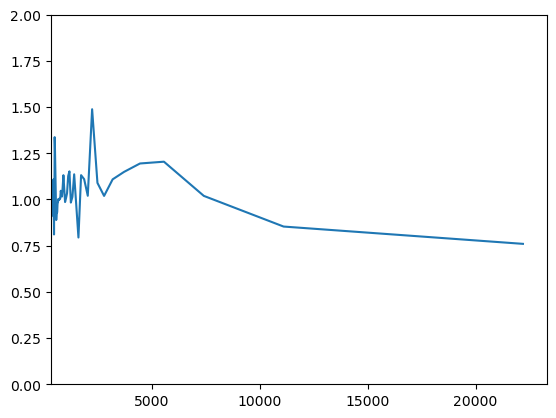

(0.0, 2.0)

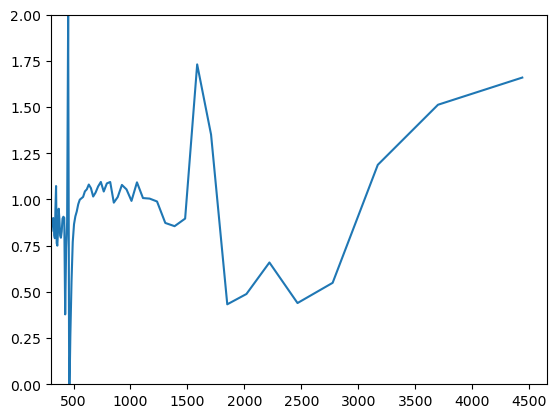

In [109]:
plt.plot(1/k_values[::-1], derivative_mean_wind_psd_good_wv1/derivative_mean_wind_psd_bad_wv1)
plt.xlim(300, None)
plt.ylim(0, 2)
plt.show()
plt.plot(1/k_values[::-1], derivative_mean_wind_psd_good_wv2/derivative_mean_wind_psd_bad_wv2)
plt.xlim(300, None)
plt.ylim(0, 2)

In [91]:
1/k_values[::-1]

array([  148.99328859,   150.        ,   151.02040816,   152.05479452,
         153.10344828,   154.16666667,   155.24475524,   156.33802817,
         157.44680851,   158.57142857,   159.71223022,   160.86956522,
         162.04379562,   163.23529412,   164.44444444,   165.67164179,
         166.91729323,   168.18181818,   169.46564885,   170.76923077,
         172.09302326,   173.4375    ,   174.80314961,   176.19047619,
         177.6       ,   179.03225806,   180.48780488,   181.96721311,
         183.47107438,   185.        ,   186.55462185,   188.13559322,
         189.74358974,   191.37931034,   193.04347826,   194.73684211,
         196.46017699,   198.21428571,   200.        ,   201.81818182,
         203.66972477,   205.55555556,   207.47663551,   209.43396226,
         211.42857143,   213.46153846,   215.53398058,   217.64705882,
         219.8019802 ,   222.        ,   224.24242424,   226.53061224,
         228.86597938,   231.25      ,   233.68421053,   236.17021277,
      

NameError: name 'df1_good' is not defined

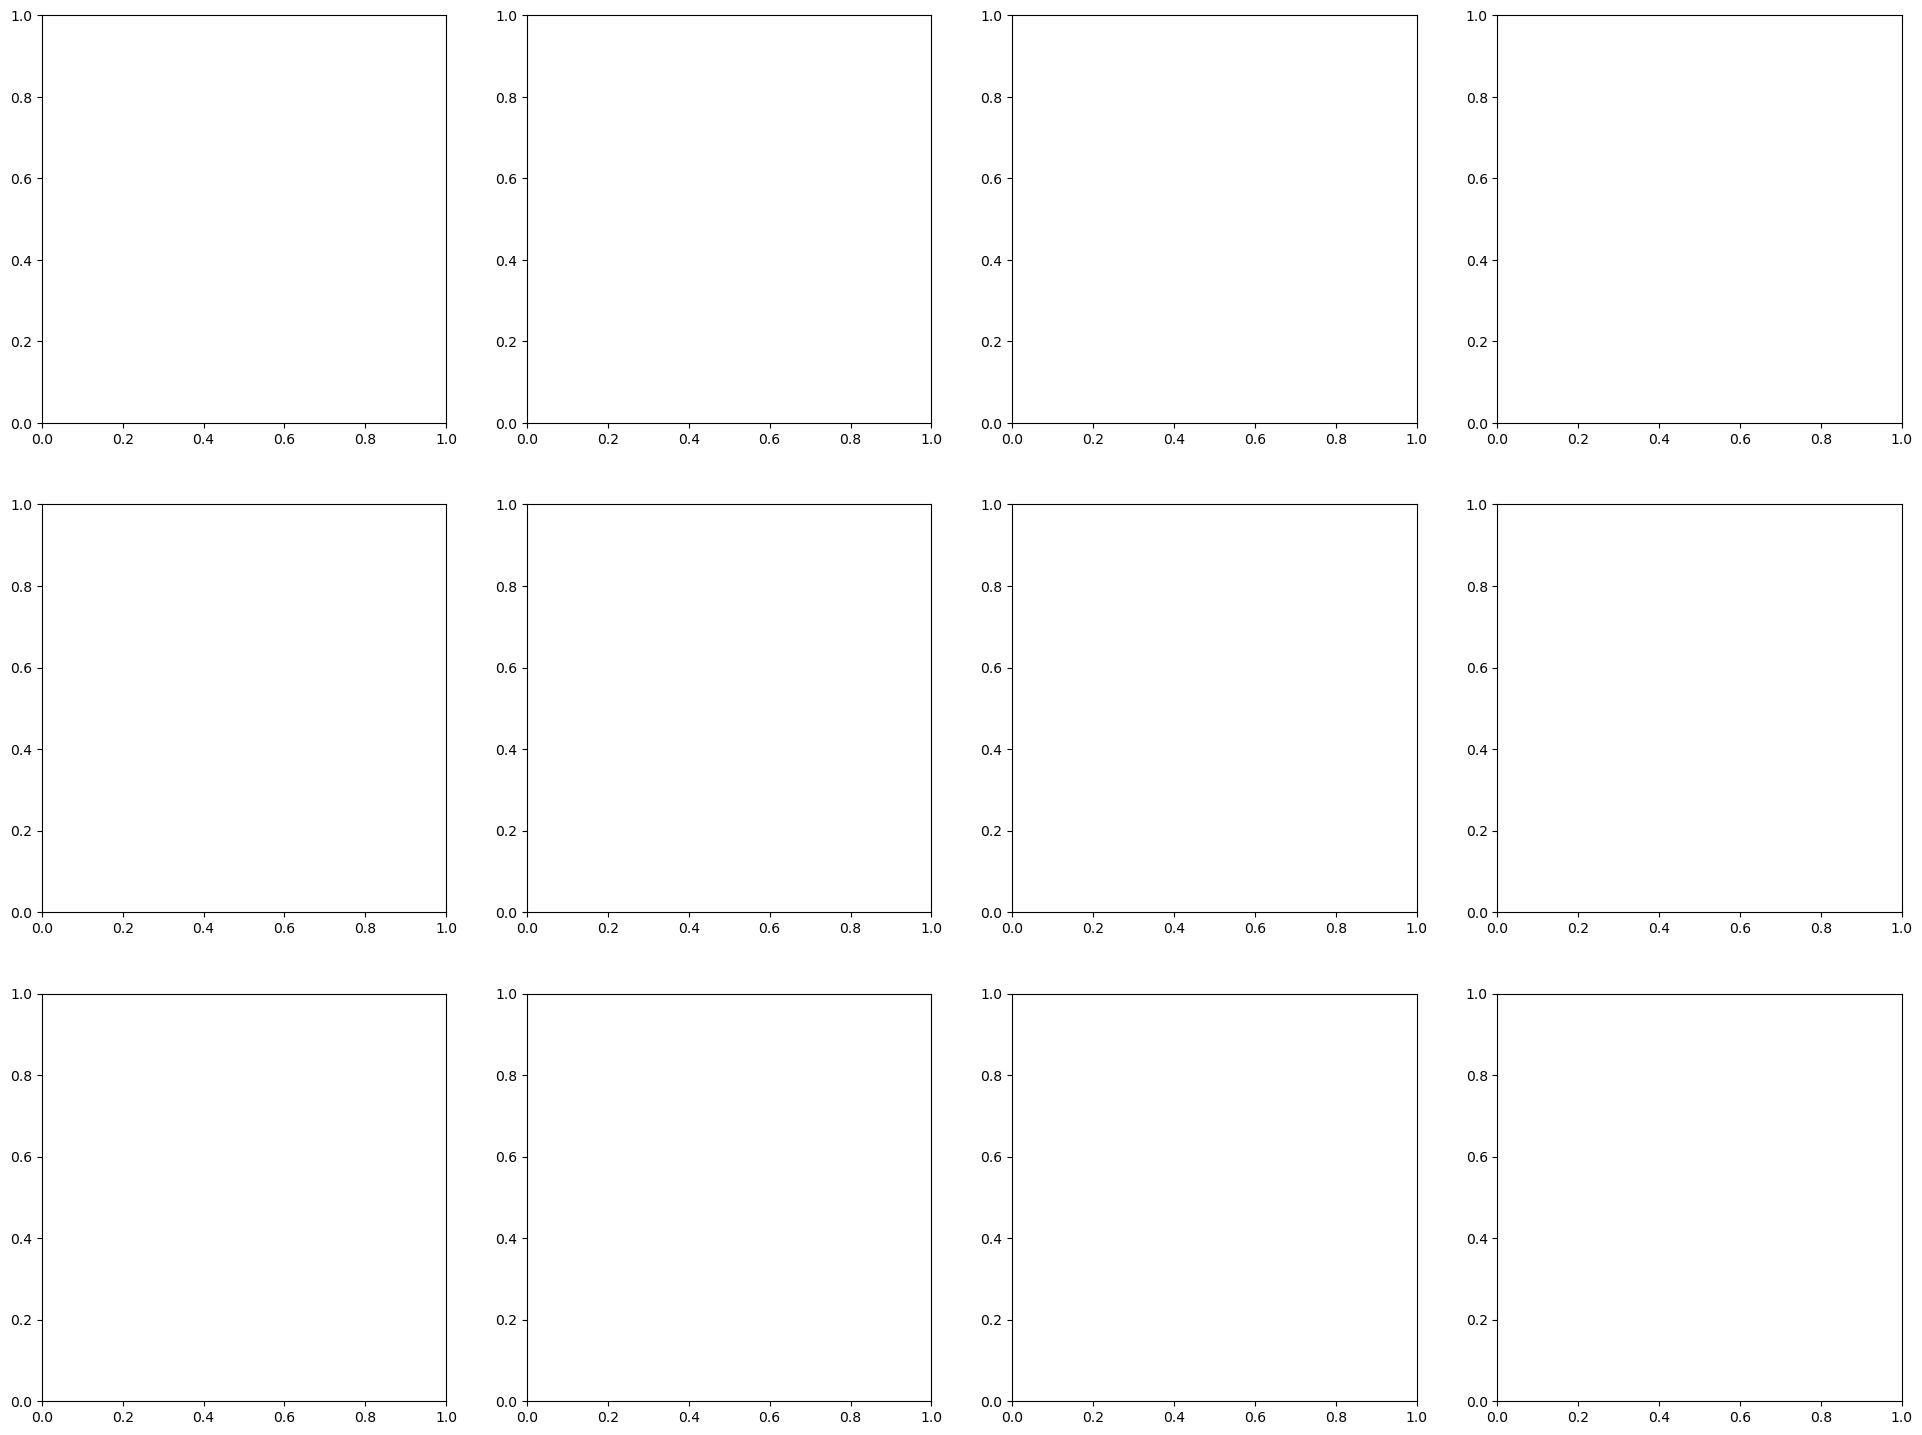

In [179]:


from scipy.stats import pearsonr


def calculate_psd_total(psd_arrays):
    """Calculate total PSD (sum across wavelengths) for each sample"""
    # Stack arrays and sum across wavelengths (axis=1)
    stacked = np.stack(psd_arrays)
    # Mask zeros and calculate sum
    masked = np.ma.masked_equal(stacked, 0)
    total_psd = np.ma.sum(masked, axis=1)
    return total_psd.filled(np.nan)

# Environmental variables to correlate with
env_vars = ['mean_b2', 'mean_b1', 'mean_b0', 'L', 'wspd', 'residual_wspd']
env_labels = ['Mean B2', 'Mean B1', 'Mean B0', 'L Parameter', 'Wind Speed', 'Residual Wind Speed']

# Get phi bins in correct order
phi_bins_unique = df1['phi_bins'].unique()
def extract_first_number(phi_range):
    import re
    match = re.search(r'\[(-?\d+(?:\.\d+)?)', phi_range)
    return float(match.group(1)) if match else 0

phi_bins = sorted(phi_bins_unique, key=extract_first_number)

# Set up the plot - 12 subplots for phi bins
n_phi_bins = len(phi_bins)
n_cols = 4
n_rows = int(np.ceil(n_phi_bins / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 6*n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)
axes = axes.flatten()

# Colors and markers
colors = {'good': '#2E8B57', 'bad': '#DC143C'}
markers = ['o', 's', '^', 'D', 'v', 'p']  # Different markers for each variable

for i, phi_bin in enumerate(phi_bins):
    ax = axes[i]
    
    # Filter data for this phi bin
    df1_good_phi = df1_good[df1_good['phi_bins'] == phi_bin].copy()
    df1_bad_phi = df1_bad[df1_bad['phi_bins'] == phi_bin].copy()
    
    print(f"Processing phi bin {phi_bin}: {len(df1_good_phi)} good, {len(df1_bad_phi)} bad")
    
    # Calculate total PSD for good and bad retrievals
    if len(df1_good_phi) > 5:
        psd_total_good = calculate_psd_total(df1_good_phi['radial_residual_psd_padded'].values)
        df1_good_phi = df1_good_phi.copy()
        df1_good_phi['psd_total'] = psd_total_good
    
    if len(df1_bad_phi) > 5:
        psd_total_bad = calculate_psd_total(df1_bad_phi['radial_residual_psd_padded'].values)
        df1_bad_phi = df1_bad_phi.copy()
        df1_bad_phi['psd_total'] = psd_total_bad
    
    # Create correlation plot for each environmental variable
    legend_elements = []
    
    for j, (var, label) in enumerate(zip(env_vars, env_labels)):
        # Plot good retrievals
        if len(df1_good_phi) > 5 and var in df1_good_phi.columns:
            # Remove NaN values
            mask_good = ~(np.isnan(df1_good_phi['psd_total']) | np.isnan(df1_good_phi[var]))
            if mask_good.sum() > 3:  # Need at least 3 points for correlation
                x_good = df1_good_phi[var][mask_good]
                y_good = df1_good_phi['psd_total'][mask_good]
                
                # Calculate correlation
                r_good, p_good = pearsonr(x_good, y_good)
                
                # Plot scatter
                ax.scatter(x_good, y_good, c=colors['good'], marker=markers[j], 
                          alpha=0.6, s=30, edgecolors='white', linewidth=0.5,
                          label=f'{label} Good (r={r_good:.2f})')
        
        # Plot bad retrievals
        if len(df1_bad_phi) > 5 and var in df1_bad_phi.columns:
            # Remove NaN values
            mask_bad = ~(np.isnan(df1_bad_phi['psd_total']) | np.isnan(df1_bad_phi[var]))
            if mask_bad.sum() > 3:  # Need at least 3 points for correlation
                x_bad = df1_bad_phi[var][mask_bad]
                y_bad = df1_bad_phi['psd_total'][mask_bad]
                
                # Calculate correlation
                r_bad, p_bad = pearsonr(x_bad, y_bad)
                
                # Plot scatter
                ax.scatter(x_bad, y_bad, c=colors['bad'], marker=markers[j], 
                          alpha=0.6, s=30, edgecolors='white', linewidth=0.5,
                          label=f'{label} Bad (r={r_bad:.2f})')
    
    # Customize subplot
    ax.set_title(f'Phi Bin: {phi_bin}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Environmental Variables (Normalized)', fontsize=10)
    ax.set_ylabel('Total PSD', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')  # Log scale for PSD
    
    # Add legend if there are data points
    if ax.collections:  # Check if any scatter plots were created
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

# Remove empty subplots
for j in range(len(phi_bins), len(axes)):
    fig.delaxes(axes[j])

# Overall plot formatting
plt.tight_layout()
plt.suptitle('PSD Correlation with Environmental Variables\n' + 
             'Good vs Bad NRCS Retrievals by Phi Bin', 
             fontsize=16, fontweight='bold', y=0.98)

plt.show()

# Create a separate correlation heatmap
print("\nCreating correlation heatmap...")

# Calculate overall correlations (combining all phi bins)
correlation_results = []

for retrieval_type in ['good', 'bad']:
    if retrieval_type == 'good':
        df_subset = df1_good.copy()
        color = colors['good']
    else:
        df_subset = df1_bad.copy()
        color = colors['bad']
    
    # Calculate total PSD
    if len(df_subset) > 0:
        psd_total = calculate_psd_total(df_subset['radial_residual_psd_padded'].values)
        df_subset['psd_total'] = psd_total
        
        # Calculate correlations
        correlations = []
        for var in env_vars:
            if var in df_subset.columns:
                mask = ~(np.isnan(df_subset['psd_total']) | np.isnan(df_subset[var]))
                if mask.sum() > 10:
                    r, p = pearsonr(df_subset['psd_total'][mask], df_subset[var][mask])
                    correlations.append(r)
                else:
                    correlations.append(np.nan)
            else:
                correlations.append(np.nan)
        
        correlation_results.append({
            'type': retrieval_type,
            'correlations': correlations
        })

# Plot correlation heatmap
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Create correlation matrix
corr_matrix = np.array([result['correlations'] for result in correlation_results])
types = [result['type'].title() for result in correlation_results]

# Create heatmap
im = ax.imshow(corr_matrix, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)

# Set ticks and labels
ax.set_xticks(range(len(env_labels)))
ax.set_xticklabels(env_labels, rotation=45, ha='right')
ax.set_yticks(range(len(types)))
ax.set_yticklabels(types)

# Add correlation values as text
for i in range(len(types)):
    for j in range(len(env_labels)):
        if not np.isnan(corr_matrix[i, j]):
            text = ax.text(j, i, f'{corr_matrix[i, j]:.2f}',
                          ha="center", va="center", color="black", fontweight='bold')

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Pearson Correlation Coefficient', rotation=270, labelpad=20)

ax.set_title('Overall PSD Correlation with Environmental Variables\nGood vs Bad Retrievals', 
             fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nOverall Correlation Summary:")
print("-" * 60)
for i, result in enumerate(correlation_results):
    print(f"\n{result['type'].upper()} Retrievals:")
    for j, (var, corr) in enumerate(zip(env_vars, result['correlations'])):
        if not np.isnan(corr):
            strength = "Strong" if abs(corr) > 0.5 else "Moderate" if abs(corr) > 0.3 else "Weak"
            direction = "positive" if corr > 0 else "negative"
            print(f"  {env_labels[j]:20s}: r = {corr:6.3f} ({strength} {direction})")
        else:
            print(f"  {env_labels[j]:20s}: r = N/A (insufficient data)")

Processing phi bin [-180, -150): 1368 good, 838 bad
Processing phi bin [-150, -120): 836 good, 215 bad
Processing phi bin [-120, -90): 617 good, 81 bad
Processing phi bin [-90, -60): 772 good, 105 bad
Processing phi bin [-60, -30): 712 good, 1411 bad
Processing phi bin [-30, 0): 537 good, 4794 bad
Processing phi bin [0, 30): 363 good, 5384 bad
Processing phi bin [30, 60): 420 good, 2431 bad
Processing phi bin [60, 90): 1244 good, 332 bad
Processing phi bin [90, 120): 3174 good, 144 bad
Processing phi bin [120, 150): 5251 good, 861 bad
Processing phi bin [150, 180): 3175 good, 1556 bad


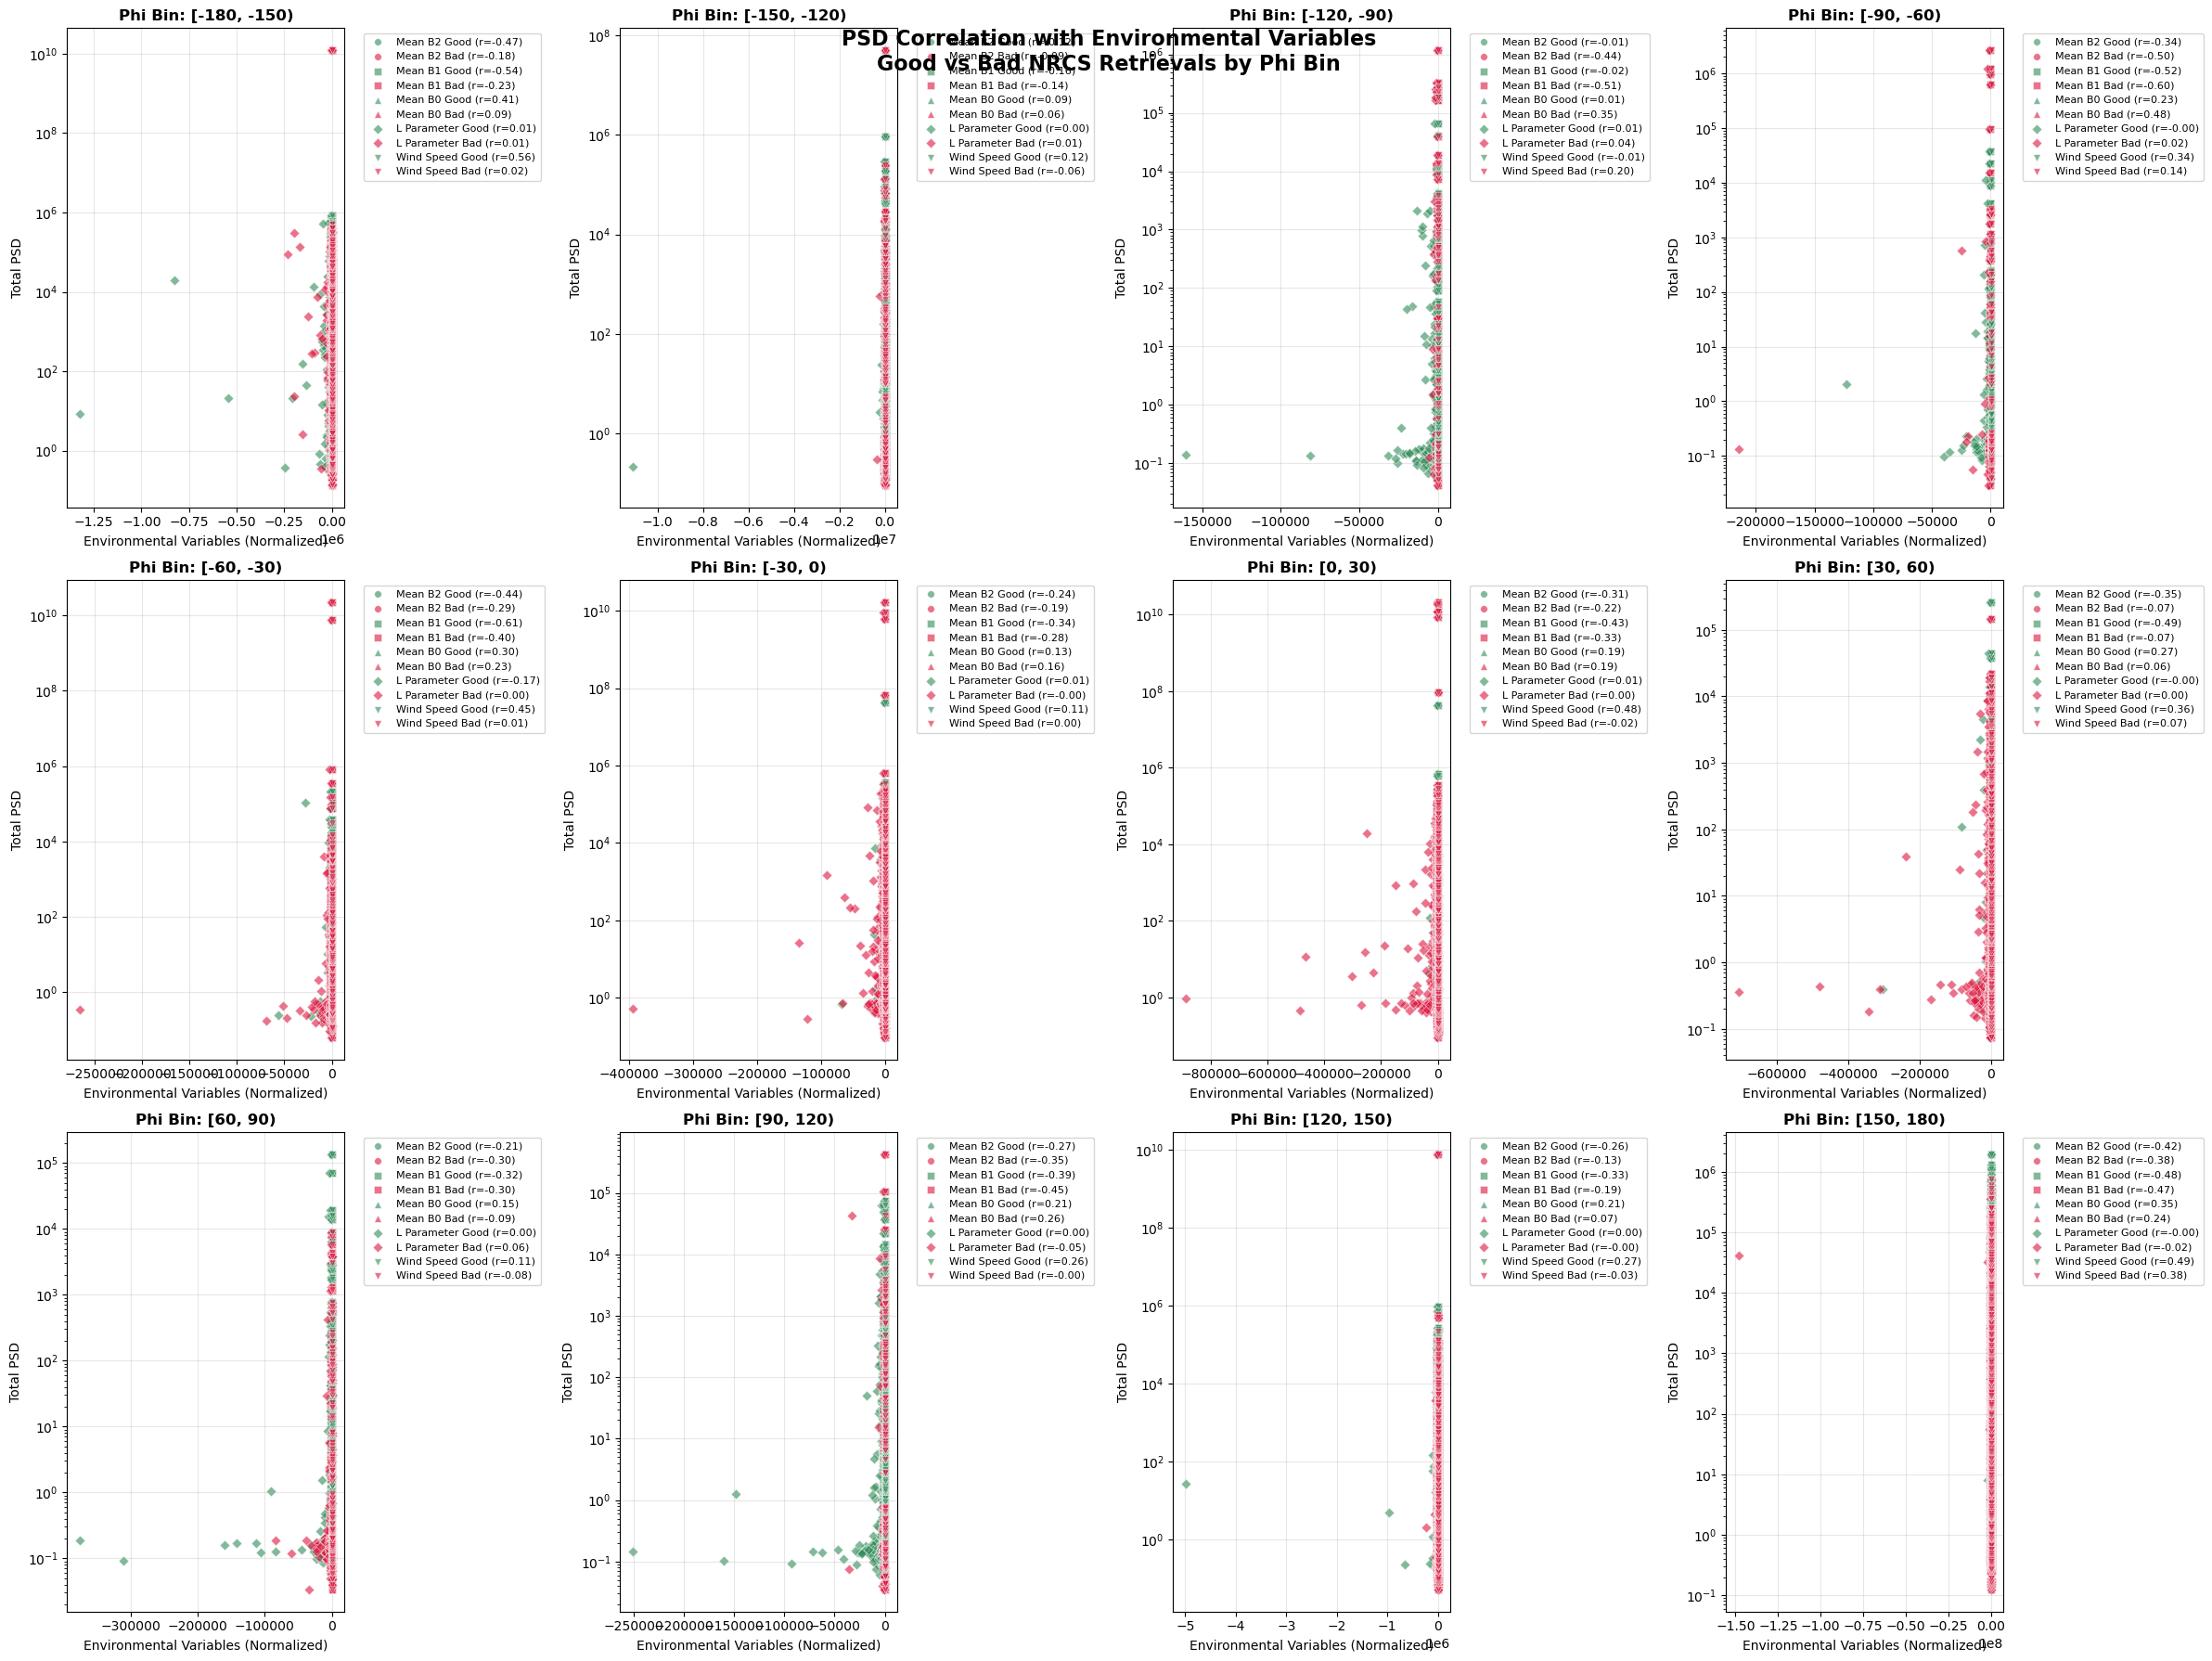


Creating correlation heatmap...


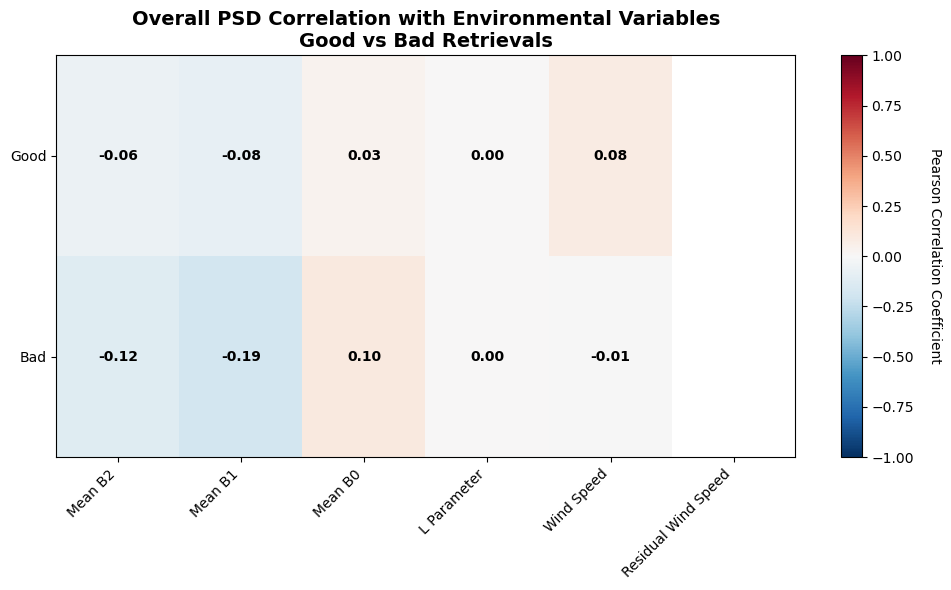


Overall Correlation Summary:
------------------------------------------------------------

GOOD Retrievals:
  Mean B2             : r = -0.057 (Weak negative)
  Mean B1             : r = -0.079 (Weak negative)
  Mean B0             : r =  0.034 (Weak positive)
  L Parameter         : r =  0.000 (Weak positive)
  Wind Speed          : r =  0.079 (Weak positive)
  Residual Wind Speed : r = N/A (insufficient data)

BAD Retrievals:
  Mean B2             : r = -0.123 (Weak negative)
  Mean B1             : r = -0.187 (Weak negative)
  Mean B0             : r =  0.096 (Weak positive)
  L Parameter         : r =  0.000 (Weak positive)
  Wind Speed          : r = -0.006 (Weak negative)
  Residual Wind Speed : r = N/A (insufficient data)


In [120]:
def calculate_psd_total(psd_arrays):
    """Calculate total PSD (sum across wavelengths) for each sample"""
    # Stack arrays and sum across wavelengths (axis=1)
    stacked = np.stack(psd_arrays)
    # Mask zeros and calculate sum
    masked = np.ma.masked_equal(stacked, 0)
    total_psd = np.ma.sum(masked, axis=1)
    return total_psd.filled(np.nan)

# Environmental variables to correlate with
env_vars = ['mean_b2', 'mean_b1', 'mean_b0', 'L', 'wspd', 'residual_wspd']
env_labels = ['Mean B2', 'Mean B1', 'Mean B0', 'L Parameter', 'Wind Speed', 'Residual Wind Speed']

# Get phi bins in correct order
phi_bins_unique = df2['phi_bins'].unique()
def extract_first_number(phi_range):
    import re
    match = re.search(r'\[(-?\d+(?:\.\d+)?)', phi_range)
    return float(match.group(1)) if match else 0

phi_bins = sorted(phi_bins_unique, key=extract_first_number)

# Set up the plot - 12 subplots for phi bins
n_phi_bins = len(phi_bins)
n_cols = 4
n_rows = int(np.ceil(n_phi_bins / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 6*n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)
axes = axes.flatten()

# Colors and markers
colors = {'good': '#2E8B57', 'bad': '#DC143C'}
markers = ['o', 's', '^', 'D', 'v', 'p']  # Different markers for each variable

for i, phi_bin in enumerate(phi_bins):
    ax = axes[i]
    
    # Filter data for this phi bin
    df1_good_phi = df1_good[df1_good['phi_bins'] == phi_bin].copy()
    df1_bad_phi = df1_bad[df1_bad['phi_bins'] == phi_bin].copy()
    
    print(f"Processing phi bin {phi_bin}: {len(df1_good_phi)} good, {len(df1_bad_phi)} bad")
    
    # Calculate total PSD for good and bad retrievals
    if len(df1_good_phi) > 5:
        psd_total_good = calculate_psd_total(df1_good_phi['radial_residual_psd_padded'].values)
        df1_good_phi = df1_good_phi.copy()
        df1_good_phi['psd_total'] = psd_total_good
    
    if len(df1_bad_phi) > 5:
        psd_total_bad = calculate_psd_total(df1_bad_phi['radial_residual_psd_padded'].values)
        df1_bad_phi = df1_bad_phi.copy()
        df1_bad_phi['psd_total'] = psd_total_bad
    
    # Create correlation plot for each environmental variable
    legend_elements = []
    
    for j, (var, label) in enumerate(zip(env_vars, env_labels)):
        # Plot good retrievals
        if len(df1_good_phi) > 5 and var in df1_good_phi.columns:
            # Remove NaN values
            mask_good = ~(np.isnan(df1_good_phi['psd_total']) | np.isnan(df1_good_phi[var]))
            if mask_good.sum() > 3:  # Need at least 3 points for correlation
                x_good = df1_good_phi[var][mask_good]
                y_good = df1_good_phi['psd_total'][mask_good]
                
                # Calculate correlation
                r_good, p_good = pearsonr(x_good, y_good)
                
                # Plot scatter
                ax.scatter(x_good, y_good, c=colors['good'], marker=markers[j], 
                          alpha=0.6, s=30, edgecolors='white', linewidth=0.5,
                          label=f'{label} Good (r={r_good:.2f})')
        
        # Plot bad retrievals
        if len(df1_bad_phi) > 5 and var in df1_bad_phi.columns:
            # Remove NaN values
            mask_bad = ~(np.isnan(df1_bad_phi['psd_total']) | np.isnan(df1_bad_phi[var]))
            if mask_bad.sum() > 3:  # Need at least 3 points for correlation
                x_bad = df1_bad_phi[var][mask_bad]
                y_bad = df1_bad_phi['psd_total'][mask_bad]
                
                # Calculate correlation
                r_bad, p_bad = pearsonr(x_bad, y_bad)
                
                # Plot scatter
                ax.scatter(x_bad, y_bad, c=colors['bad'], marker=markers[j], 
                          alpha=0.6, s=30, edgecolors='white', linewidth=0.5,
                          label=f'{label} Bad (r={r_bad:.2f})')
    
    # Customize subplot
    ax.set_title(f'Phi Bin: {phi_bin}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Environmental Variables (Normalized)', fontsize=10)
    ax.set_ylabel('Total PSD', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')  # Log scale for PSD
    
    # Add legend if there are data points
    if ax.collections:  # Check if any scatter plots were created
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

# Remove empty subplots
for j in range(len(phi_bins), len(axes)):
    fig.delaxes(axes[j])

# Overall plot formatting
plt.tight_layout()
plt.suptitle('PSD Correlation with Environmental Variables\n' + 
             'Good vs Bad NRCS Retrievals by Phi Bin', 
             fontsize=16, fontweight='bold', y=0.98)

plt.show()

# Create a separate correlation heatmap
print("\nCreating correlation heatmap...")

# Calculate overall correlations (combining all phi bins)
correlation_results = []

for retrieval_type in ['good', 'bad']:
    if retrieval_type == 'good':
        df_subset = df1_good.copy()
        color = colors['good']
    else:
        df_subset = df1_bad.copy()
        color = colors['bad']
    
    # Calculate total PSD
    if len(df_subset) > 0:
        psd_total = calculate_psd_total(df_subset['radial_residual_psd_padded'].values)
        df_subset['psd_total'] = psd_total
        
        # Calculate correlations
        correlations = []
        for var in env_vars:
            if var in df_subset.columns:
                mask = ~(np.isnan(df_subset['psd_total']) | np.isnan(df_subset[var]))
                if mask.sum() > 10:
                    r, p = pearsonr(df_subset['psd_total'][mask], df_subset[var][mask])
                    correlations.append(r)
                else:
                    correlations.append(np.nan)
            else:
                correlations.append(np.nan)
        
        correlation_results.append({
            'type': retrieval_type,
            'correlations': correlations
        })

# Plot correlation heatmap
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Create correlation matrix
corr_matrix = np.array([result['correlations'] for result in correlation_results])
types = [result['type'].title() for result in correlation_results]

# Create heatmap
im = ax.imshow(corr_matrix, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)

# Set ticks and labels
ax.set_xticks(range(len(env_labels)))
ax.set_xticklabels(env_labels, rotation=45, ha='right')
ax.set_yticks(range(len(types)))
ax.set_yticklabels(types)

# Add correlation values as text
for i in range(len(types)):
    for j in range(len(env_labels)):
        if not np.isnan(corr_matrix[i, j]):
            text = ax.text(j, i, f'{corr_matrix[i, j]:.2f}',
                          ha="center", va="center", color="black", fontweight='bold')

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Pearson Correlation Coefficient', rotation=270, labelpad=20)

ax.set_title('Overall PSD Correlation with Environmental Variables\nGood vs Bad Retrievals', 
             fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nOverall Correlation Summary:")
print("-" * 60)
for i, result in enumerate(correlation_results):
    print(f"\n{result['type'].upper()} Retrievals:")
    for j, (var, corr) in enumerate(zip(env_vars, result['correlations'])):
        if not np.isnan(corr):
            strength = "Strong" if abs(corr) > 0.5 else "Moderate" if abs(corr) > 0.3 else "Weak"
            direction = "positive" if corr > 0 else "negative"
            print(f"  {env_labels[j]:20s}: r = {corr:6.3f} ({strength} {direction})")
        else:
            print(f"  {env_labels[j]:20s}: r = N/A (insufficient data)")

=== WIND FIELD BIAS ANALYSIS BY PHI_BINS ===

Bias = wind_field_median - wspd
Positive bias = overestimation, Negative bias = underestimation

              wspd_mean  wspd_std  wspd_count  wind_field_median_mean  \
phi_bins                                                                
[-120, -90)      16.829     1.645         719                  14.646   
[-150, -120)     16.840     1.747        1082                  14.486   
[-180, -150)     16.788     1.606        2392                  15.594   
[-30, 0)         16.816     1.580        5533                  16.703   
[-60, -30)       16.747     1.471        2433                  17.316   
[-90, -60)       16.737     1.554         909                  16.644   
[0, 30)          16.921     1.650        5702                  16.595   
[120, 150)       16.887     1.631        5959                  15.211   
[150, 180)       16.862     1.628        4920                  15.314   
[30, 60)         16.899     1.674        2717         

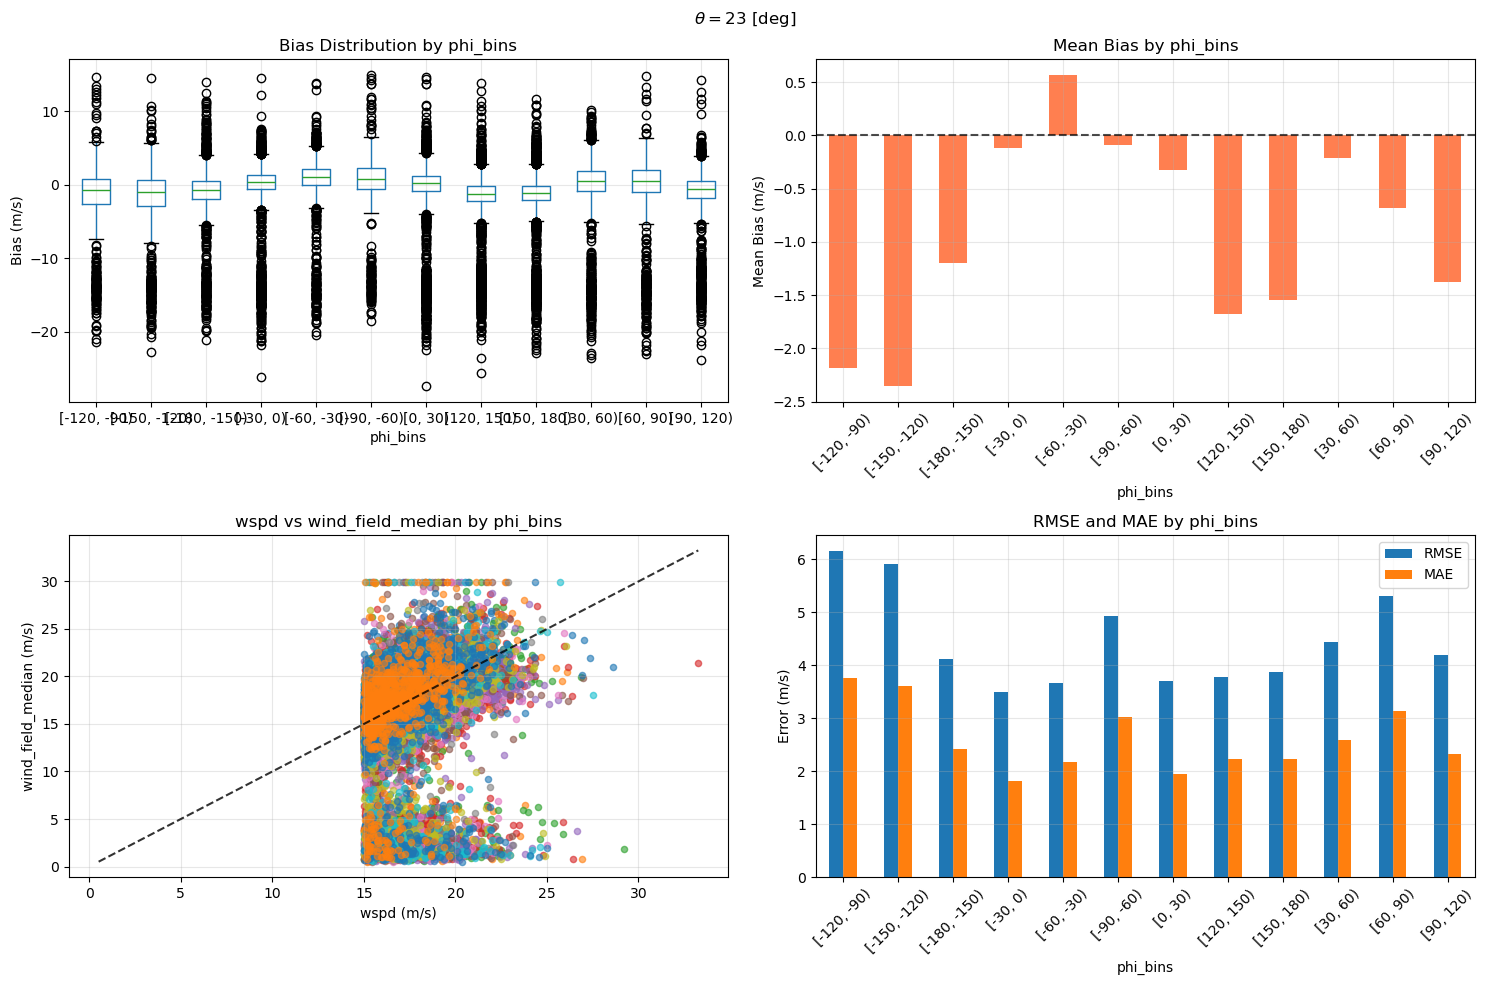


=== INTERPRETATION GUIDE ===
• Mean Bias: Average difference (retrieved - true)
  - Positive = systematic overestimation
  - Negative = systematic underestimation
• MAE: Mean Absolute Error (average magnitude of errors)
• RMSE: Root Mean Square Error (penalizes larger errors more)
• Correlation: Linear relationship strength (-1 to 1)
• Relative Bias %: Bias as percentage of true mean value
=== WIND FIELD BIAS ANALYSIS BY PHI_BINS ===

Bias = wind_field_median - wspd
Positive bias = overestimation, Negative bias = underestimation

              wspd_mean  wspd_std  wspd_count  wind_field_median_mean  \
phi_bins                                                                
[-120, -90)      16.858     1.740         698                  17.344   
[-150, -120)     16.726     1.669        1051                  18.117   
[-180, -150)     16.861     1.675        2206                  19.433   
[-30, 0)         16.848     1.605        5331                  14.277   
[-60, -30)       16.828  

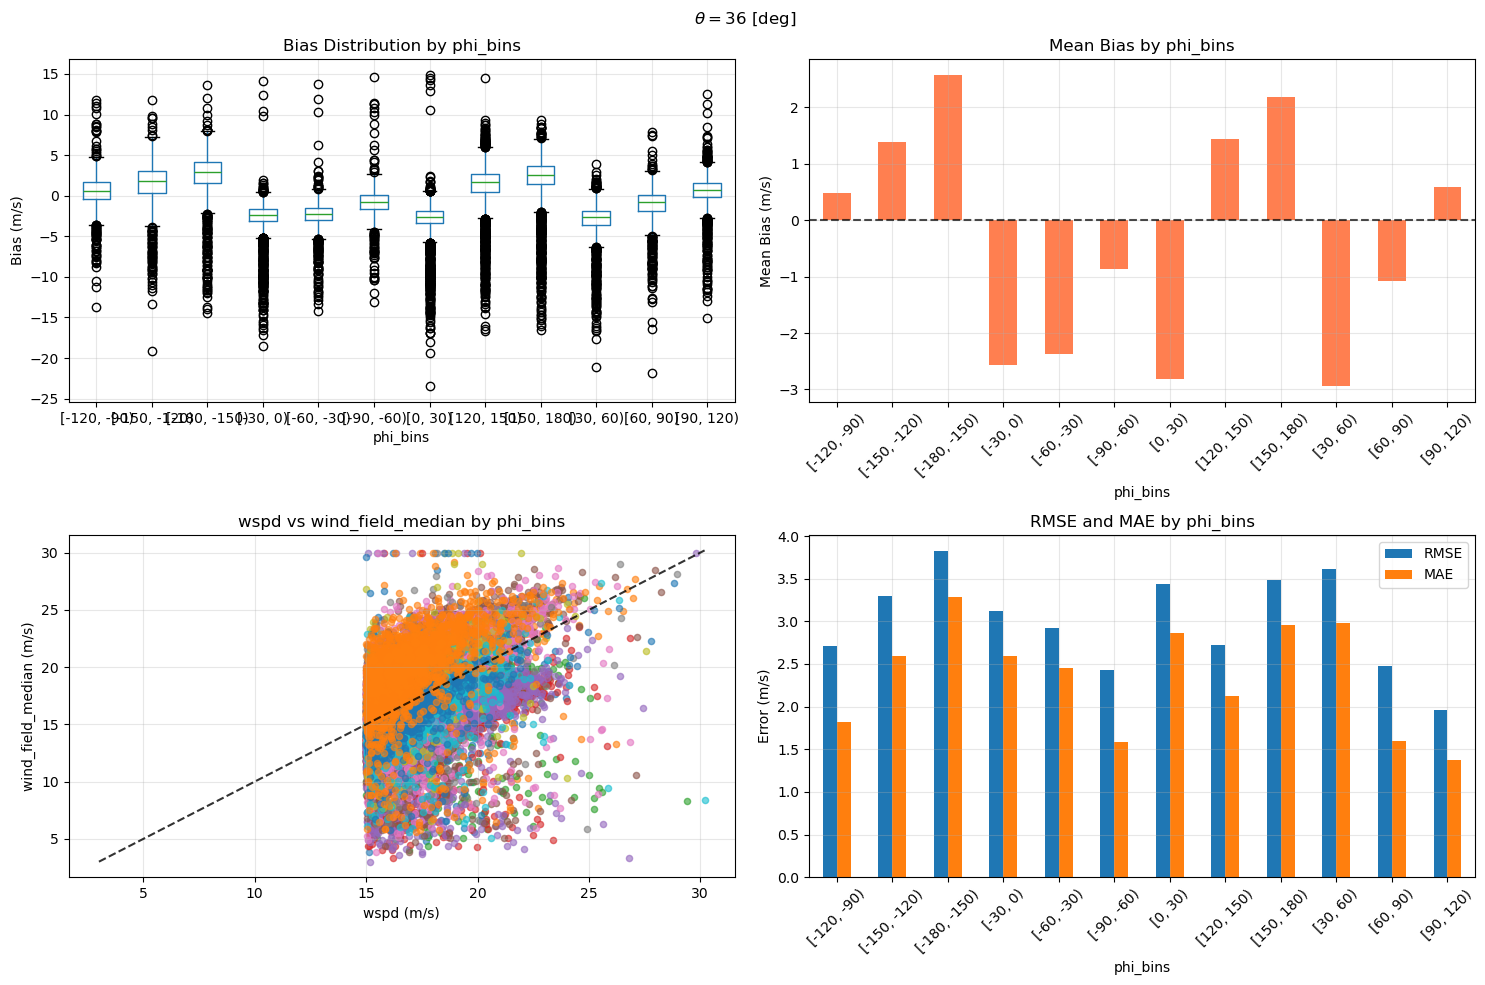


=== INTERPRETATION GUIDE ===
• Mean Bias: Average difference (retrieved - true)
  - Positive = systematic overestimation
  - Negative = systematic underestimation
• MAE: Mean Absolute Error (average magnitude of errors)
• RMSE: Root Mean Square Error (penalizes larger errors more)
• Correlation: Linear relationship strength (-1 to 1)
• Relative Bias %: Bias as percentage of true mean value


In [258]:
bias_results = analyze_wind_bias(df1, "$\\theta = 23$ [deg]", true_col="wspd")
bias_results = analyze_wind_bias(df2, "$\\theta = 36$ [deg]", true_col='wspd')

In [21]:
k_thresh = 1/2000
sub2_mask = k_values > k_thresh

df1w['sub2_energy'] = df1w['radial_wind_psd_padded'].apply(lambda x: np.sum(x[sub2_mask]))
df2w['sub2_energy'] = df2w['radial_wind_psd_padded'].apply(lambda x: np.sum(x[sub2_mask]))

In [22]:
df1w_median_sub2energy = np.median(df1w['sub2_energy'])
df2w_median_sub2energy = np.median(df2w['sub2_energy'])

In [23]:
df1w['variability_label'] = df1w['sub2_energy'].apply(lambda x: 'High' if x > df1w_median_sub2energy else 'Low')
df2w['variability_label'] = df2w['sub2_energy'].apply(lambda x: 'High' if x > df2w_median_sub2energy else 'Low')

In [24]:
df1w['wspd_error'] = df1w['wind_field_median'] - df1w['era5_wspd']
df2w['wspd_error'] = df2w['wind_field_median'] - df2w['era5_wspd']

In [25]:
mean_error_high = df1w[df1w['variability_label'] == 'High']['wspd_error'].mean()
mean_error_low = df1w[df1w['variability_label'] == 'Low']['wspd_error'].mean()

In [26]:
ub2_mask = k_values > k_thresh  # mask for high-frequency bins

# Apply to both datasets
df1w['sub2_energy'] = df1w['radial_wind_psd_padded'].apply(lambda x: np.sum(np.array(x)[sub2_mask]))
df2w['sub2_energy'] = df2w['radial_wind_psd_padded'].apply(lambda x: np.sum(np.array(x)[sub2_mask]))

# Step 2: Binning by variability
df1w_median_sub2energy = df1w['sub2_energy'].median()
df2w_median_sub2energy = df2w['sub2_energy'].median()

df1w['variability_label'] = df1w['sub2_energy'].apply(lambda x: 'High' if x > df1w_median_sub2energy else 'Low')
df2w['variability_label'] = df2w['sub2_energy'].apply(lambda x: 'High' if x > df2w_median_sub2energy else 'Low')

# Step 3: Compute error
df1w['wspd_error'] = df1w['wind_field_median'] - df1w['era5_wspd']
df2w['wspd_error'] = df2w['wind_field_median'] - df2w['era5_wspd']

# Step 4: Compute stats (optional)
mean_error_high_wv1 = df1w[df1w['variability_label'] == 'High']['wspd_error'].mean()
mean_error_low_wv1 = df1w[df1w['variability_label'] == 'Low']['wspd_error'].mean()
std_error_high_wv1 = df1w[df1w['variability_label'] == 'High']['wspd_error'].std()
std_error_low_wv1 = df1w[df1w['variability_label'] == 'Low']['wspd_error'].std()

mean_error_high_wv2 = df2w[df2w['variability_label'] == 'High']['wspd_error'].mean()
mean_error_low_wv2 = df2w[df2w['variability_label'] == 'Low']['wspd_error'].mean()
std_error_high_wv2 = df2w[df2w['variability_label'] == 'High']['wspd_error'].std()
std_error_low_wv2 = df2w[df2w['variability_label'] == 'Low']['wspd_error'].std()

In [1]:
print("=======PSDs filtered at < 2 km=======")
print(f"WV1 High Variability Mean Error: {mean_error_high_wv1:.2f}, Std: {std_error_high_wv1:.2f}")
print(f"WV1 Low Variability Mean Error: {mean_error_low_wv1:.2f}, Std: {std_error_low_wv1:.2f}")
print(f"WV2 High Variability Mean Error: {mean_error_high_wv2:.2f}, Std: {std_error_high_wv2:.2f}")
print(f"WV2 Low Variability Mean Error: {mean_error_low_wv2:.2f}, Std: {std_error_low_wv2:.2f}")

=======PSDs filtered at < 2 km=======


NameError: name 'mean_error_high_wv1' is not defined

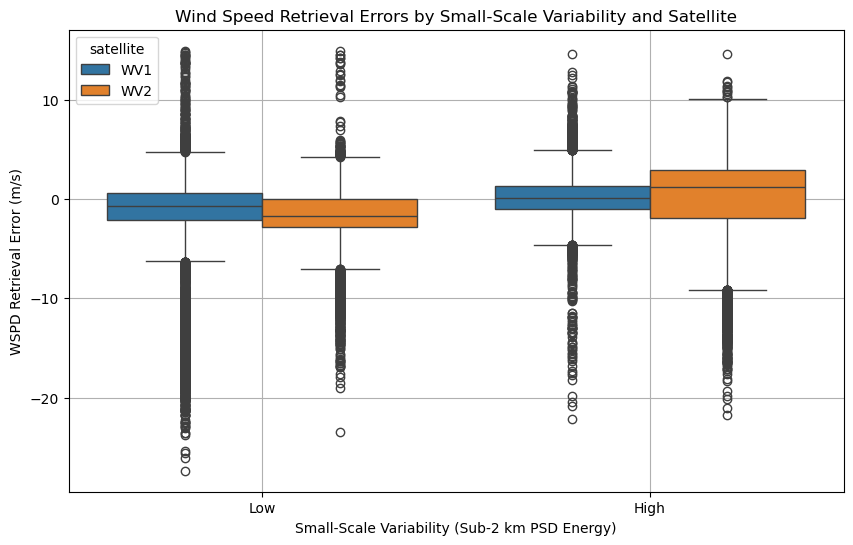

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

df1w['satellite'] = 'WV1'
df2w['satellite'] = 'WV2'

df_all = pd.concat([df1w, df2w])

plt.figure(figsize=(10,6))
sns.boxplot(data=df_all, x='variability_label', y='wspd_error', hue='satellite')
plt.title('Wind Speed Retrieval Errors by Small-Scale Variability and Satellite')
plt.ylabel('WSPD Retrieval Error (m/s)')
plt.xlabel('Small-Scale Variability (Sub-2 km PSD Energy)')
plt.grid(True)
plt.show()


=======PSDs filtered at > 2 km=======
WV1 High Variability Mean Error: 0.51, Std: 2.11
WV1 Low Variability Mean Error: -2.30, Std: 4.97
WV2 High Variability Mean Error: 0.78, Std: 2.67
WV2 Low Variability Mean Error: -1.93, Std: 3.20


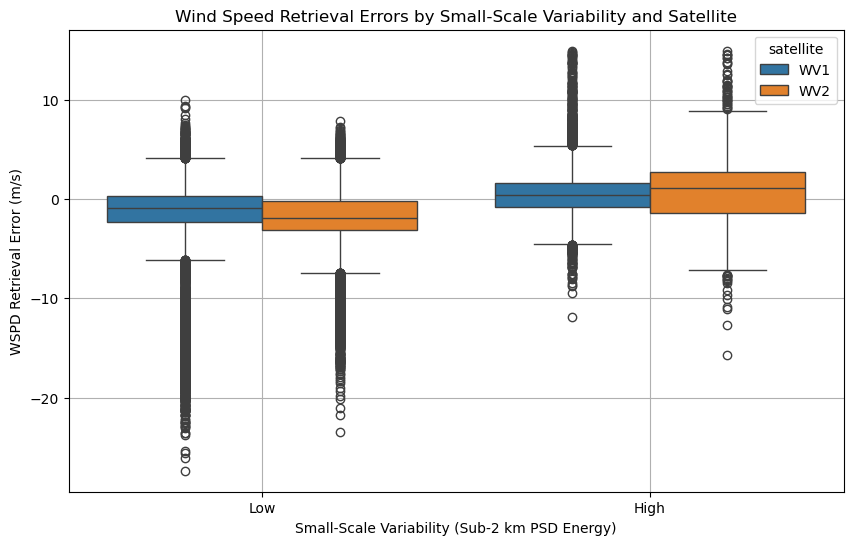

In [29]:
sub2_mask = k_values < k_thresh  # mask for high-frequency bins

# Apply to both datasets
df1w['sub2_energy'] = df1w['radial_wind_psd_padded'].apply(lambda x: np.sum(np.array(x)[sub2_mask]))
df2w['sub2_energy'] = df2w['radial_wind_psd_padded'].apply(lambda x: np.sum(np.array(x)[sub2_mask]))

# Step 2: Binning by variability
df1w_median_sub2energy = df1w['sub2_energy'].median()
df2w_median_sub2energy = df2w['sub2_energy'].median()

df1w['variability_label'] = df1w['sub2_energy'].apply(lambda x: 'High' if x > df1w_median_sub2energy else 'Low')
df2w['variability_label'] = df2w['sub2_energy'].apply(lambda x: 'High' if x > df2w_median_sub2energy else 'Low')

# Step 3: Compute error
df1w['wspd_error'] = df1w['wind_field_median'] - df1w['era5_wspd']
df2w['wspd_error'] = df2w['wind_field_median'] - df2w['era5_wspd']

# Step 4: Compute stats (optional)
mean_error_high_wv1 = df1w[df1w['variability_label'] == 'High']['wspd_error'].mean()
mean_error_low_wv1 = df1w[df1w['variability_label'] == 'Low']['wspd_error'].mean()
std_error_high_wv1 = df1w[df1w['variability_label'] == 'High']['wspd_error'].std()
std_error_low_wv1 = df1w[df1w['variability_label'] == 'Low']['wspd_error'].std()

mean_error_high_wv2 = df2w[df2w['variability_label'] == 'High']['wspd_error'].mean()
mean_error_low_wv2 = df2w[df2w['variability_label'] == 'Low']['wspd_error'].mean()
std_error_high_wv2 = df2w[df2w['variability_label'] == 'High']['wspd_error'].std()
std_error_low_wv2 = df2w[df2w['variability_label'] == 'Low']['wspd_error'].std()

print("=======PSDs filtered at > 2 km=======")
print(f"WV1 High Variability Mean Error: {mean_error_high_wv1:.2f}, Std: {std_error_high_wv1:.2f}")
print(f"WV1 Low Variability Mean Error: {mean_error_low_wv1:.2f}, Std: {std_error_low_wv1:.2f}")
print(f"WV2 High Variability Mean Error: {mean_error_high_wv2:.2f}, Std: {std_error_high_wv2:.2f}")
print(f"WV2 Low Variability Mean Error: {mean_error_low_wv2:.2f}, Std: {std_error_low_wv2:.2f}")

df1w['satellite'] = 'WV1'
df2w['satellite'] = 'WV2'

df_all = pd.concat([df1w, df2w])

plt.figure(figsize=(10,6))
sns.boxplot(data=df_all, x='variability_label', y='wspd_error', hue='satellite')
plt.title('Wind Speed Retrieval Errors by Small-Scale Variability and Satellite')
plt.ylabel('WSPD Retrieval Error (m/s)')
plt.xlabel('Small-Scale Variability (Sub-2 km PSD Energy)')
plt.grid(True)
plt.show()


=======PSDs filtered nowhere =======
WV1 High Variability Mean Error: 0.51, Std: 2.11
WV1 Low Variability Mean Error: -2.30, Std: 4.97
WV2 High Variability Mean Error: 0.78, Std: 2.67
WV2 Low Variability Mean Error: -1.93, Std: 3.20


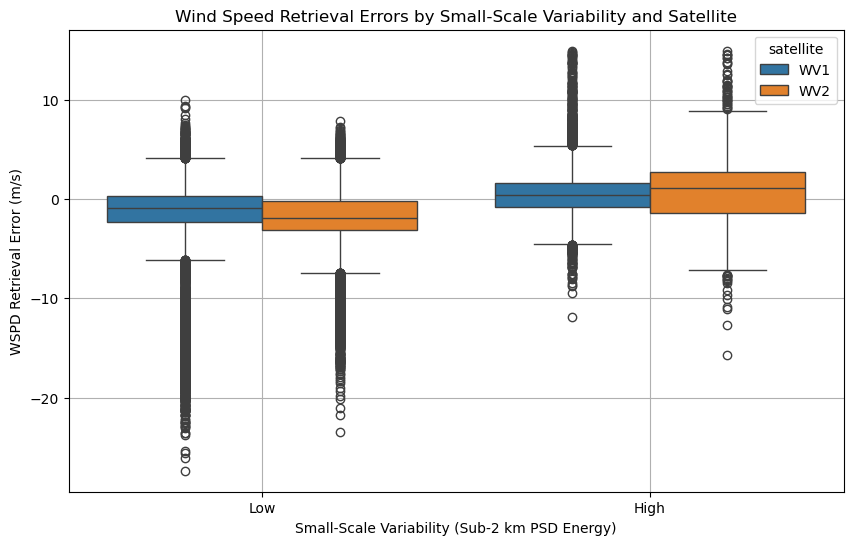

In [30]:
sub2_mask = None  # mask for high-frequency bins

# Apply to both datasets
df1w['sub2_energy'] = df1w['radial_wind_psd_padded'].apply(lambda x: np.sum(np.array(x)[sub2_mask]))
df2w['sub2_energy'] = df2w['radial_wind_psd_padded'].apply(lambda x: np.sum(np.array(x)[sub2_mask]))

# Step 2: Binning by variability
df1w_median_sub2energy = df1w['sub2_energy'].median()
df2w_median_sub2energy = df2w['sub2_energy'].median()

df1w['variability_label'] = df1w['sub2_energy'].apply(lambda x: 'High' if x > df1w_median_sub2energy else 'Low')
df2w['variability_label'] = df2w['sub2_energy'].apply(lambda x: 'High' if x > df2w_median_sub2energy else 'Low')

# Step 3: Compute error
df1w['wspd_error'] = df1w['wind_field_median'] - df1w['era5_wspd']
df2w['wspd_error'] = df2w['wind_field_median'] - df2w['era5_wspd']

# Step 4: Compute stats (optional)
mean_error_high_wv1 = df1w[df1w['variability_label'] == 'High']['wspd_error'].mean()
mean_error_low_wv1 = df1w[df1w['variability_label'] == 'Low']['wspd_error'].mean()
std_error_high_wv1 = df1w[df1w['variability_label'] == 'High']['wspd_error'].std()
std_error_low_wv1 = df1w[df1w['variability_label'] == 'Low']['wspd_error'].std()

mean_error_high_wv2 = df2w[df2w['variability_label'] == 'High']['wspd_error'].mean()
mean_error_low_wv2 = df2w[df2w['variability_label'] == 'Low']['wspd_error'].mean()
std_error_high_wv2 = df2w[df2w['variability_label'] == 'High']['wspd_error'].std()
std_error_low_wv2 = df2w[df2w['variability_label'] == 'Low']['wspd_error'].std()

print("=======PSDs filtered nowhere =======")
print(f"WV1 High Variability Mean Error: {mean_error_high_wv1:.2f}, Std: {std_error_high_wv1:.2f}")
print(f"WV1 Low Variability Mean Error: {mean_error_low_wv1:.2f}, Std: {std_error_low_wv1:.2f}")
print(f"WV2 High Variability Mean Error: {mean_error_high_wv2:.2f}, Std: {std_error_high_wv2:.2f}")
print(f"WV2 Low Variability Mean Error: {mean_error_low_wv2:.2f}, Std: {std_error_low_wv2:.2f}")

df1w['satellite'] = 'WV1'
df2w['satellite'] = 'WV2'

df_all = pd.concat([df1w, df2w])

plt.figure(figsize=(10,6))
sns.boxplot(data=df_all, x='variability_label', y='wspd_error', hue='satellite')
plt.title('Wind Speed Retrieval Errors by Small-Scale Variability and Satellite')
plt.ylabel('WSPD Retrieval Error (m/s)')
plt.xlabel('Small-Scale Variability (Sub-2 km PSD Energy)')
plt.grid(True)
plt.show()


In [31]:
# d = compute_directional_differences(df1, df2, df1r, df2r, df1w, df2w, k_values, phi_res=1)
# plot_directional_differences(d, k_valuesa, plot_type='wavelength', cmap='RdBu_r', 
#                              max_wavelength=100, vmin=-1e6, vmax=1e6)

Performing block bootstrap with 1038 samples, block size 32, and 1000 replicates


100%|██████████| 1000/1000 [00:01<00:00, 811.43it/s]


Performing block bootstrap with 1129 samples, block size 33, and 1000 replicates


100%|██████████| 1000/1000 [00:01<00:00, 658.38it/s]


Performing block bootstrap with 418 samples, block size 20, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 4113.30it/s]


Performing block bootstrap with 405 samples, block size 20, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 4598.72it/s]


Performing block bootstrap with 253 samples, block size 15, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 5253.18it/s]


Performing block bootstrap with 255 samples, block size 15, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 5794.88it/s]


Performing block bootstrap with 236 samples, block size 15, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 6076.39it/s]

Performing block bootstrap with 259 samples, block size 16, and 1000 replicates



100%|██████████| 1000/1000 [00:00<00:00, 6492.46it/s]


Performing block bootstrap with 406 samples, block size 20, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 4899.84it/s]


Performing block bootstrap with 446 samples, block size 21, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 4909.78it/s]


Performing block bootstrap with 1369 samples, block size 37, and 1000 replicates


100%|██████████| 1000/1000 [00:01<00:00, 682.39it/s]


Performing block bootstrap with 1447 samples, block size 38, and 1000 replicates


100%|██████████| 1000/1000 [00:01<00:00, 580.12it/s]


Performing block bootstrap with 2278 samples, block size 47, and 1000 replicates


100%|██████████| 1000/1000 [00:02<00:00, 399.71it/s]


Performing block bootstrap with 2381 samples, block size 48, and 1000 replicates


100%|██████████| 1000/1000 [00:02<00:00, 376.22it/s]


Performing block bootstrap with 1337 samples, block size 36, and 1000 replicates


100%|██████████| 1000/1000 [00:01<00:00, 721.91it/s]


Performing block bootstrap with 1262 samples, block size 35, and 1000 replicates


100%|██████████| 1000/1000 [00:01<00:00, 710.94it/s]


Performing block bootstrap with 540 samples, block size 23, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 3514.23it/s]


Performing block bootstrap with 518 samples, block size 22, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 3641.03it/s]


Performing block bootstrap with 640 samples, block size 25, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 3480.48it/s]


Performing block bootstrap with 542 samples, block size 23, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 3788.71it/s]


Performing block bootstrap with 1844 samples, block size 42, and 1000 replicates


100%|██████████| 1000/1000 [00:01<00:00, 531.51it/s]


Performing block bootstrap with 1778 samples, block size 42, and 1000 replicates


100%|██████████| 1000/1000 [00:01<00:00, 539.43it/s]


Performing block bootstrap with 2211 samples, block size 47, and 1000 replicates


100%|██████████| 1000/1000 [00:02<00:00, 448.25it/s]


Performing block bootstrap with 2166 samples, block size 46, and 1000 replicates


100%|██████████| 1000/1000 [00:02<00:00, 454.00it/s]


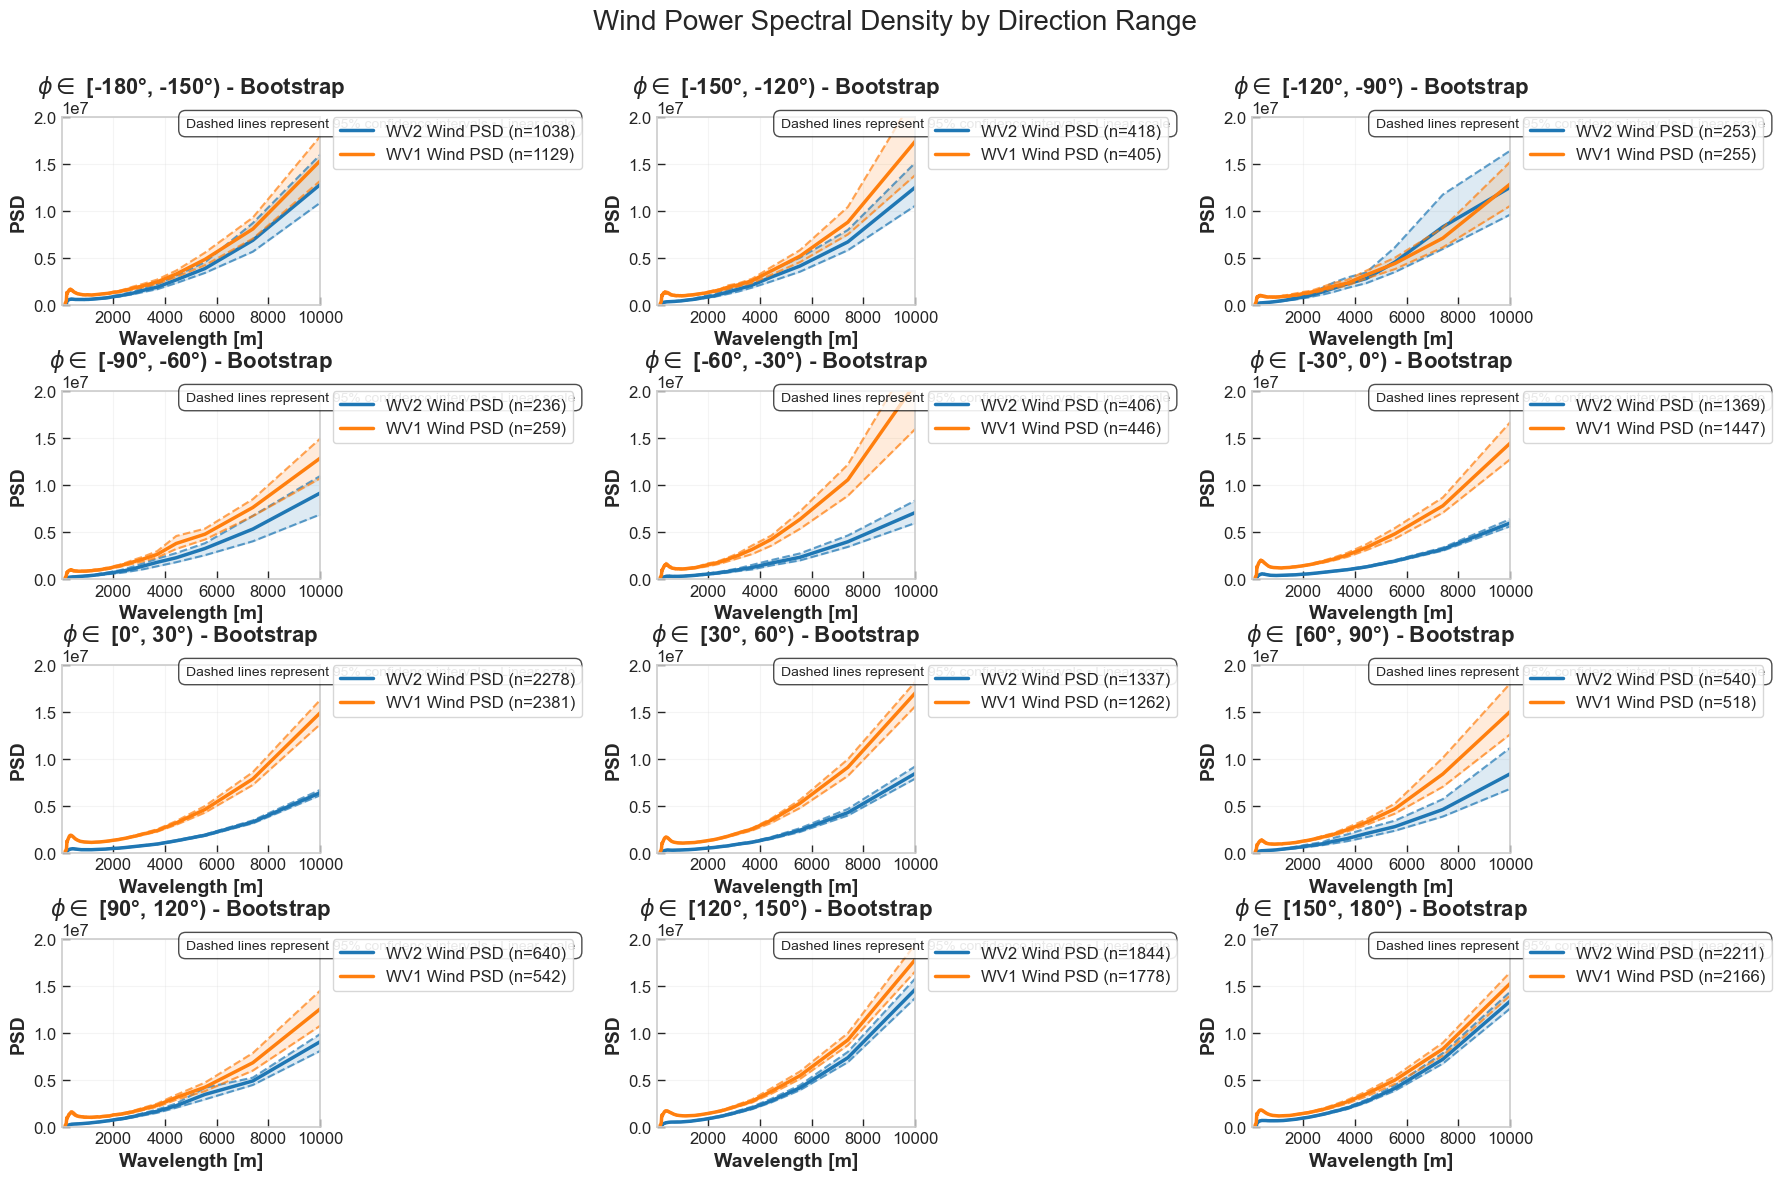

In [ ]:
intervals = np.arange(-180, 181, 30)

# Create the figure and axes
fig, axes = plt.subplots(4, 3, figsize=(18, 12))

# Flatten the 2D array of axes
flat_axes = axes.flatten()

for i in range(len(intervals)-1):
    a = intervals[i]
    b = intervals[i+1]
    
    # Skip if we've run out of axes
    if i >= len(flat_axes):
        print(f"Warning: Not enough axes for interval {a} to {b}")
        continue
        
    # Get the current axis
    current_ax = flat_axes[i]
    
    # Construct filtered DataFrames for the current interval
    # df1_filtered, df1r_filtered, df1w_filtered, df2_filtered, df2r_filtered, df2w_filtered = construct_df(a, b, df1, df1r, df1w, df2, df2r, df2w)
    # df1_filtered = filter_similar_atmospheric_conditions(df1_filtered, L_range=(-1e6, -1000))
    # df2_filtered = filter_similar_atmospheric_conditions(df2_filtered, L_range=(-1e6, -1000))

    df1r_filtered = df1r_filtered[df1r_filtered["renamed_filename"].isin(df1_filtered["renamed_filename"])]
    df2r_filtered = df2r_filtered[df2r_filtered["renamed_filename"].isin(df2_filtered["renamed_filename"])]

    df1w_filtered = df1w_filtered[df1w_filtered["renamed_filename"].isin(df1_filtered["renamed_filename"])]
    df2w_filtered = df2w_filtered[df2w_filtered["renamed_filename"].isin(df2_filtered["renamed_filename"])]

    # Plot on the current axis
    _, _ = plot_avg_spectral_density(k_values, [df2w_filtered, df1w_filtered],
                              ["WV2 Wind PSD", "WV1 Wind PSD"],
                              f"$\\phi \\in$ [{a}°, {b}°)", 
                              x_range=(0.0001, 0.15), y_range=(0, 0.2e8),
                              use_log_scale=False, wavelength=True, bootstrap=True,
                              ax=current_ax)  

# Hide any unused axes
for j in range(i+1, len(flat_axes)):
    flat_axes[j].set_visible(False)

# Add a common title for the entire figure
fig.suptitle('Wind Power Spectral Density by Direction Range', fontsize=20, y=0.98)

# Adjust spacing between subplots
plt.tight_layout(rect=[0, 0, 1, 0.96])  # The rect parameter reserves space for the suptitle

# Show the figure
plt.show()

Performing block bootstrap with 1132 samples, block size 33, and 1000 replicates


100%|██████████| 1000/1000 [00:01<00:00, 773.13it/s]


Performing block bootstrap with 405 samples, block size 20, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 4247.55it/s]


Performing block bootstrap with 255 samples, block size 15, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 6236.55it/s]


Performing block bootstrap with 259 samples, block size 16, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 6807.95it/s]


Performing block bootstrap with 446 samples, block size 21, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 4124.42it/s]


Performing block bootstrap with 1448 samples, block size 38, and 1000 replicates


100%|██████████| 1000/1000 [00:01<00:00, 573.73it/s]


Performing block bootstrap with 2381 samples, block size 48, and 1000 replicates


100%|██████████| 1000/1000 [00:02<00:00, 357.43it/s]


Performing block bootstrap with 1262 samples, block size 35, and 1000 replicates


100%|██████████| 1000/1000 [00:01<00:00, 647.97it/s]


Performing block bootstrap with 518 samples, block size 22, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 3712.68it/s]


Performing block bootstrap with 542 samples, block size 23, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 3515.84it/s]


Performing block bootstrap with 1781 samples, block size 42, and 1000 replicates


100%|██████████| 1000/1000 [00:02<00:00, 466.60it/s]


Performing block bootstrap with 2171 samples, block size 46, and 1000 replicates


100%|██████████| 1000/1000 [00:02<00:00, 372.09it/s]


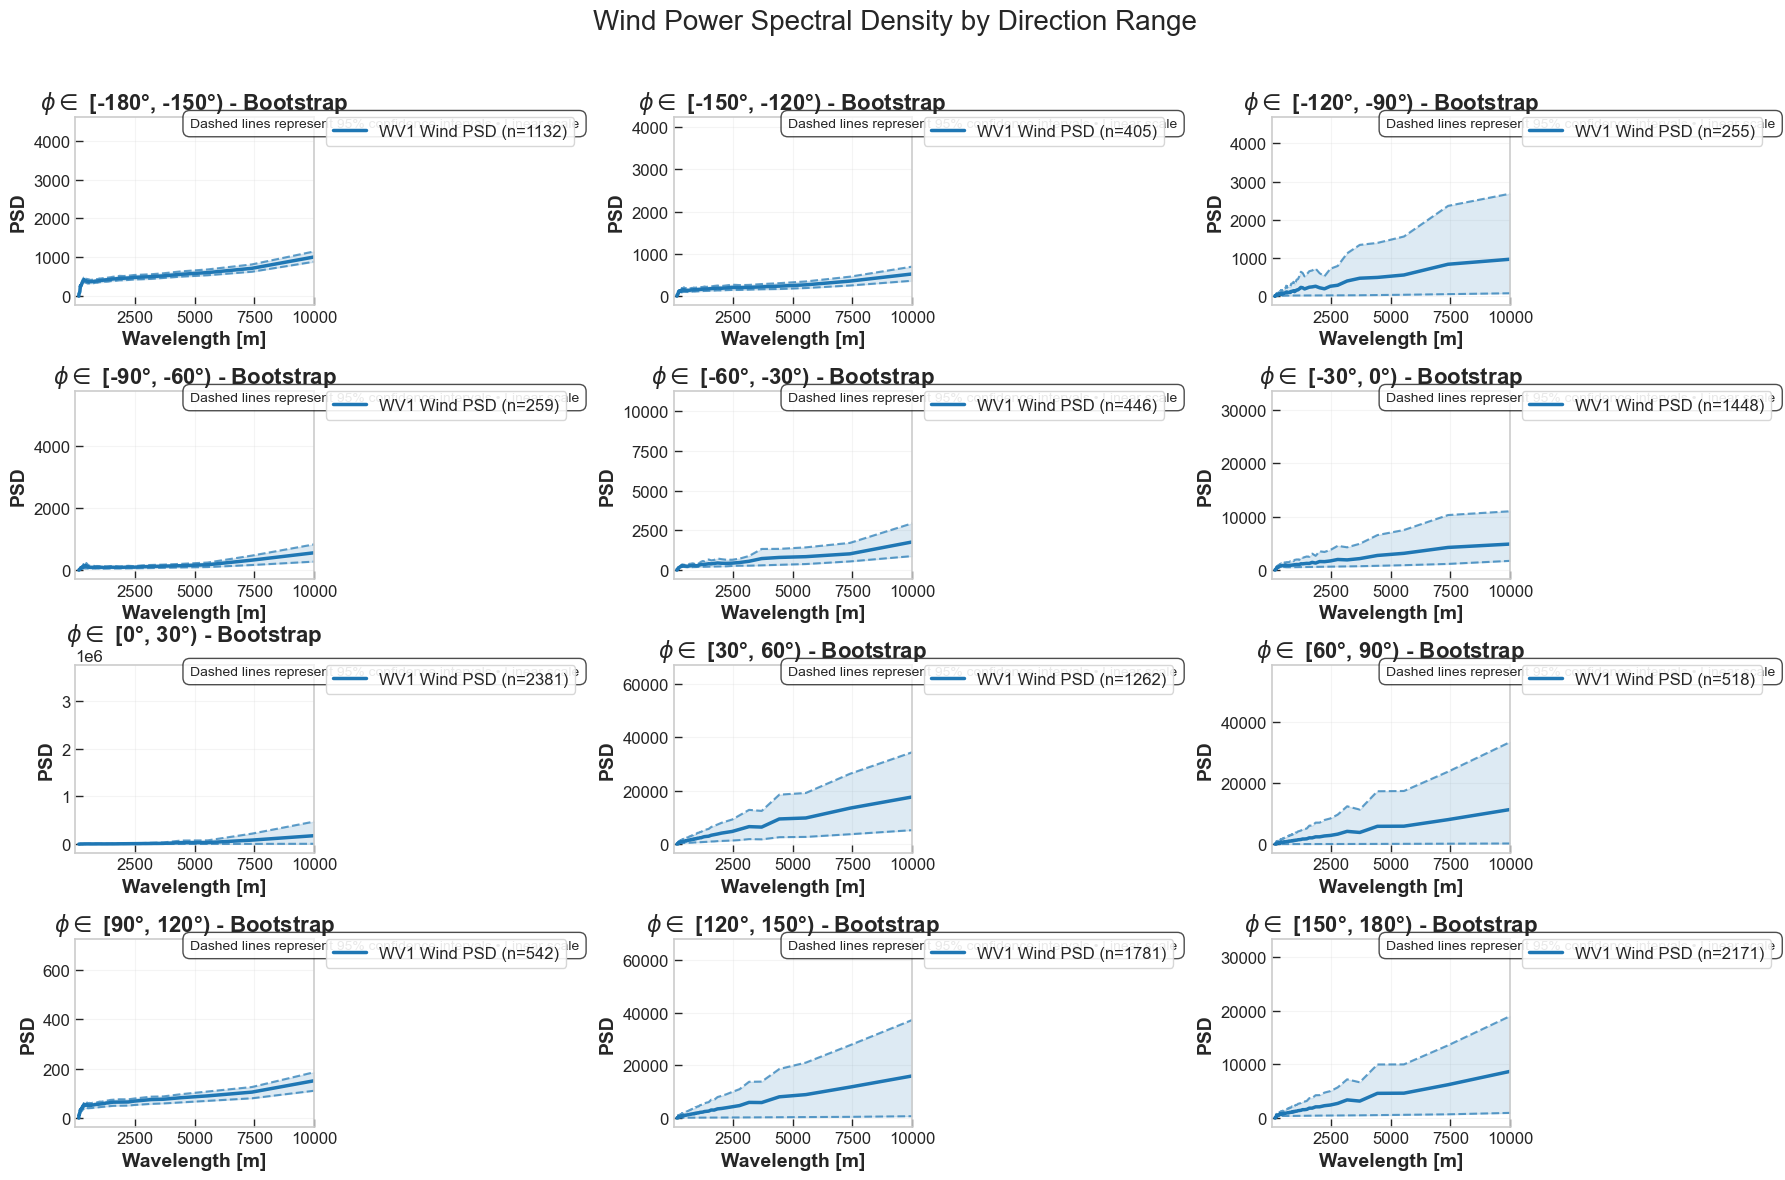

In [58]:
intervals = np.arange(-180, 181, 30)

# Create the figure and axes
fig, axes = plt.subplots(4, 3, figsize=(18, 12))

# Flatten the 2D array of axes
flat_axes = axes.flatten()

for i in range(len(intervals)-1):
    a = intervals[i]
    b = intervals[i+1]
    
    # Skip if we've run out of axes
    if i >= len(flat_axes):
        print(f"Warning: Not enough axes for interval {a} to {b}")
        continue
        
    # Get the current axis
    current_ax = flat_axes[i]
    
    # Construct filtered DataFrames for the current interval
    df1_filtered, df1r_filtered, df1w_filtered, df2_filtered, df2r_filtered, df2w_filtered = construct_df(a, b, df1, df1r, df1w, df2, df2r, df2w)
    df1_filtered = filter_similar_atmospheric_conditions(df1_filtered, L_range=(-1e6, -1000))
    # df2_filtered = filter_similar_atmospheric_conditions(df2_filtered, L_range=(-1e6, -1000))

    df1r_filtered = df1r_filtered[df1r_filtered["renamed_filename"].isin(df1_filtered["renamed_filename"])]
    # df2r_filtered = df2r_filtered[df2r_filtered["renamed_filename"].isin(df2_filtered["renamed_filename"])]

    df1w_filtered = df1w_filtered[df1w_filtered["renamed_filename"].isin(df1_filtered["renamed_filename"])]
    # df2w_filtered = df2w_filtered[df2w_filtered["renamed_filename"].isin(df2_filtered["renamed_filename"])]

    # Plot on the current axis
    _, _ = plot_avg_spectral_density(k_values, [df1w_filtered],
                              ["WV1 Wind PSD"],
                              f"$\\phi \\in$ [{a}°, {b}°)", 
                            #   x_range=(0.0001, 0.15), y_range=(0, 0.2e8),
                            x_range=(0.0001, 0.15), #y_range=(0, 0.2e4), 
                              use_log_scale=False, wavelength=True, bootstrap=True,
                              ax=current_ax, column_name='radial_residual_psd_padded')  

# Hide any unused axes
for j in range(i+1, len(flat_axes)):
    flat_axes[j].set_visible(False)

# Add a common title for the entire figure
fig.suptitle('Wind Power Spectral Density by Direction Range', fontsize=20, y=0.98)

# Adjust spacing between subplots
plt.tight_layout(rect=[0, 0, 1, 0.96])  # The rect parameter reserves space for the suptitle

# Show the figure
plt.show()

Performing block bootstrap with 1038 samples, block size 32, and 1000 replicates


100%|██████████| 1000/1000 [00:01<00:00, 823.36it/s]


Performing block bootstrap with 418 samples, block size 20, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 4179.06it/s]


Performing block bootstrap with 253 samples, block size 15, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 7143.96it/s]


Performing block bootstrap with 236 samples, block size 15, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 7175.80it/s]


Performing block bootstrap with 406 samples, block size 20, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 4703.54it/s]


Performing block bootstrap with 1369 samples, block size 37, and 1000 replicates


100%|██████████| 1000/1000 [00:05<00:00, 174.83it/s]


Performing block bootstrap with 2278 samples, block size 47, and 1000 replicates


100%|██████████| 1000/1000 [00:08<00:00, 122.21it/s]


Performing block bootstrap with 1337 samples, block size 36, and 1000 replicates


100%|██████████| 1000/1000 [00:05<00:00, 175.76it/s]


Performing block bootstrap with 540 samples, block size 23, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 1304.31it/s]


Performing block bootstrap with 640 samples, block size 25, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 1049.22it/s]


Performing block bootstrap with 1844 samples, block size 42, and 1000 replicates


100%|██████████| 1000/1000 [00:08<00:00, 123.09it/s]


Performing block bootstrap with 2211 samples, block size 47, and 1000 replicates


100%|██████████| 1000/1000 [00:07<00:00, 139.48it/s]


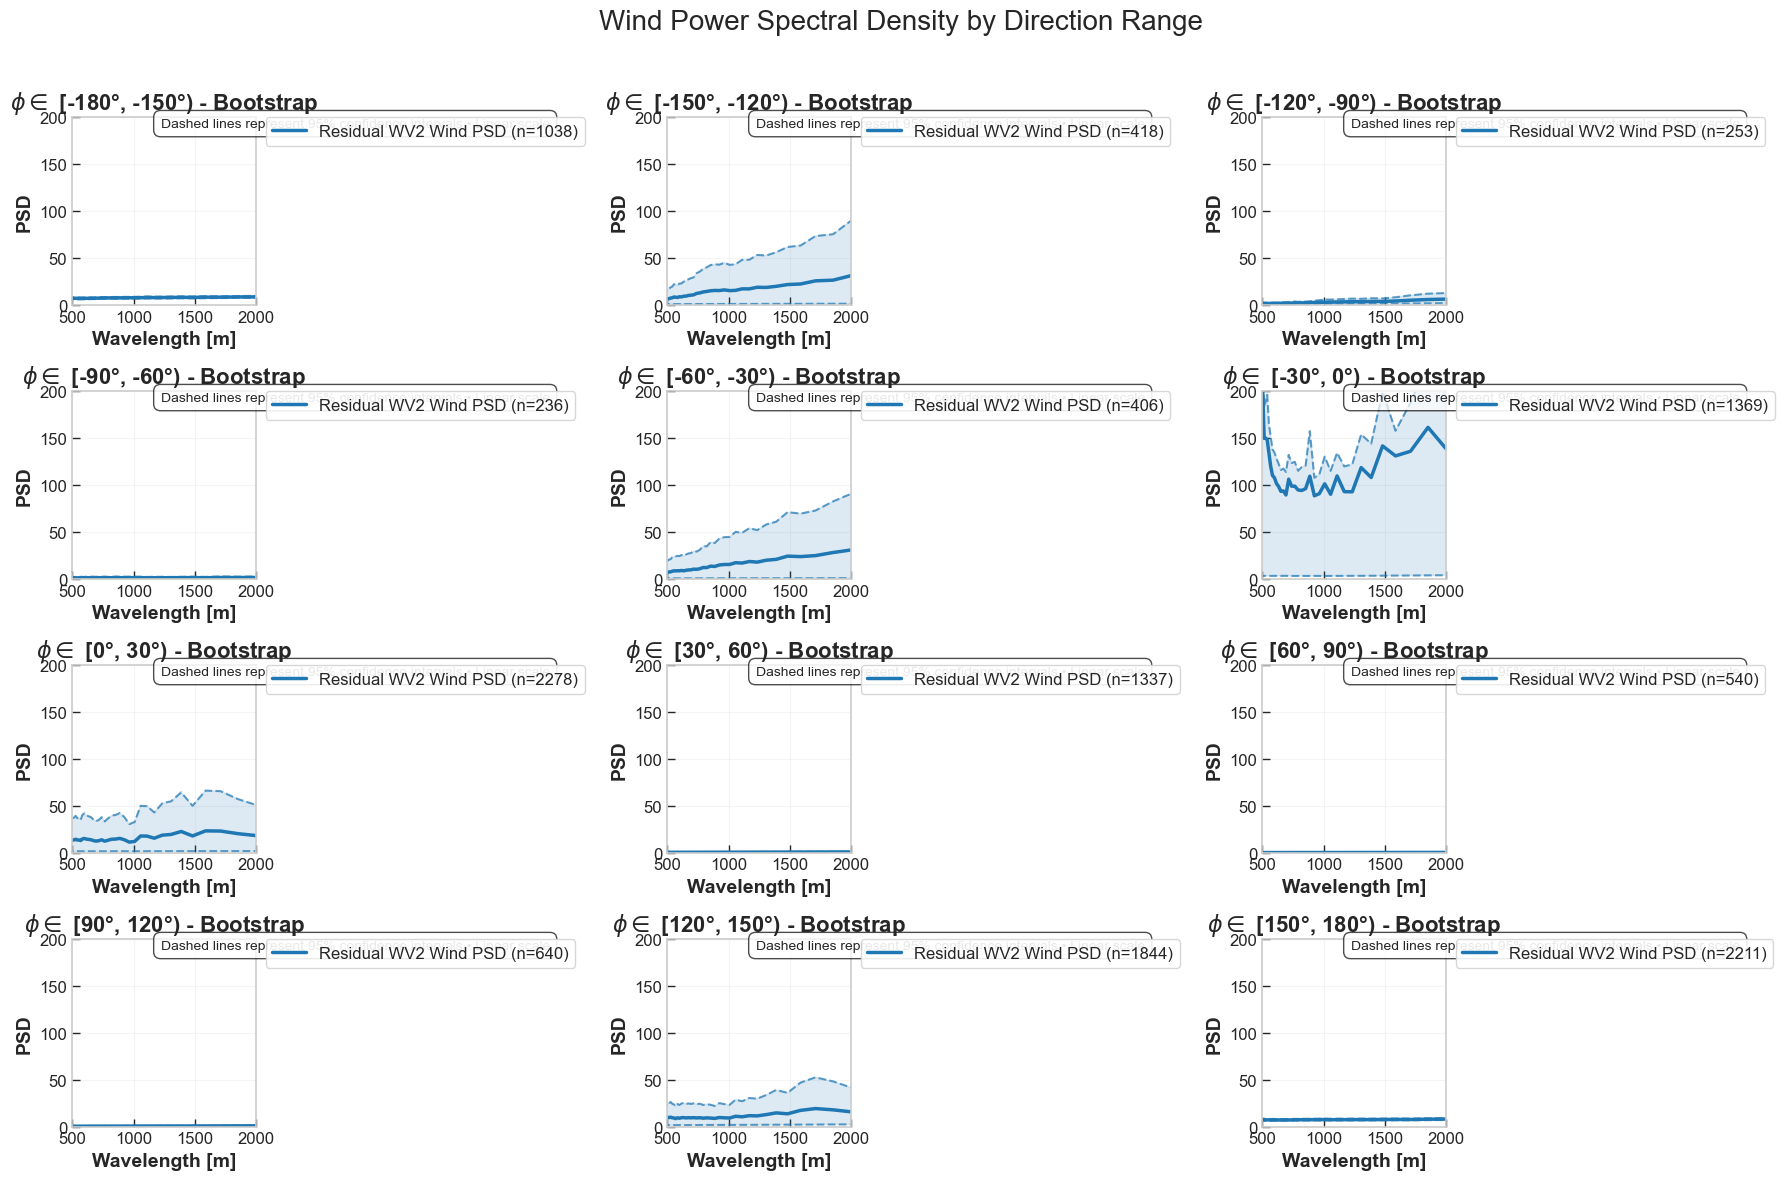

In [192]:
intervals = np.arange(-180, 181, 30)

# Create the figure and axes
fig, axes = plt.subplots(4, 3, figsize=(18, 12))

# Flatten the 2D array of axes
flat_axes = axes.flatten()

for i in range(len(intervals)-1):
    a = intervals[i]
    b = intervals[i+1]
    
    # Skip if we've run out of axes
    if i >= len(flat_axes):
        print(f"Warning: Not enough axes for interval {a} to {b}")
        continue
        
    # Get the current axis
    current_ax = flat_axes[i]
    
    # Construct filtered DataFrames for the current interval
    df1_filtered, df1r_filtered, df1w_filtered, df2_filtered, df2r_filtered, df2w_filtered = construct_df(a, b, df1, df1r, df1w, df2, df2r, df2w)
    # df1_filtered = filter_similar_atmospheric_conditions(df1_filtered, L_range=(-1e6, -1000))
    df2_filtered = filter_similar_atmospheric_conditions(df2_filtered, L_range=(-1e6, -1000))

    # df1r_filtered = df1r_filtered[df1r_filtered["renamed_filename"].isin(df1_filtered["renamed_filename"])]
    df2r_filtered = df2r_filtered[df2r_filtered["renamed_filename"].isin(df2_filtered["renamed_filename"])]

    # df1w_filtered = df1w_filtered[df1w_filtered["renamed_filename"].isin(df1_filtered["renamed_filename"])]
    df2w_filtered = df2w_filtered[df2w_filtered["renamed_filename"].isin(df2_filtered["renamed_filename"])]

    # Plot on the current axis
    _, _ = plot_avg_spectral_density(k_values, [df2w_filtered, ],
                              ["Residual WV2 Wind PSD"],
                              f"$\\phi \\in$ [{a}°, {b}°)", 
                            #   x_range=(0.0001, 0.15), y_range=(0, 0.2e8),
                            x_range=(1/2000, 1/500), y_range=(0, 200), 
                              use_log_scale=False, wavelength=True, bootstrap=True,
                              ax=current_ax, column_name='radial_residual_psd_padded')  

# Hide any unused axes
for j in range(i+1, len(flat_axes)):
    flat_axes[j].set_visible(False)

# Add a common title for the entire figure
fig.suptitle('Wind Power Spectral Density by Direction Range', fontsize=20, y=0.98)

# Adjust spacing between subplots
plt.tight_layout(rect=[0, 0, 1, 0.96])  # The rect parameter reserves space for the suptitle

# Show the figure
plt.show()

In [ ]:
# df1_m180_m150, df1r_m180_m150, df1w_m180_m150, df2_m180_m150, df2r_m180_m150, df2w_m180_m150 = construct_df(-180, -150, df1, df1r, df1w, df2, df2r, df2w)
# df1_m150_m120, df1r_m150_m120, df1w_m150_m120, df2_m150_m120, df2r_m150_m120, df2w_m150_m120 = construct_df(-150, -120, df1, df1r, df1w, df2, df2r, df2w)
# df1_m120_m90, df1r_m120_m90, df1w_m120_m90, df2_m120_m90, df2r_m120_m90, df2w_m120_m90 = construct_df(-120, -90, df1, df1r, df1w, df2, df2r, df2w)
# df1_m90_m60, df1r_m90_m60, df1w_m90_m60, df2_m90_m60, df2r_m90_m60, df2w_m90_m60 = construct_df(-90, -60, df1, df1r, df1w, df2, df2r, df2w)
# df1_m60_m30, df1r_m60_m30, df1w_m60_m30, df2_m60_m30, df2r_m60_m30, df2w_m60_m30 = construct_df(-60, -30, df1, df1r, df1w, df2, df2r, df2w)
# df1_m30_0, df1r_m30_0, df1w_m30_0, df2_m30_0, df2r_m30_0, df2w_m30_0 = construct_df(-30, 0, df1, df1r, df1w, df2, df2r, df2w)
# df1_0_30, df1r_0_30, df1w_0_30, df2_0_30, df2r_0_30, df2w_0_30 = construct_df(0, 30, df1, df1r, df1w, df2, df2r, df2w)
# df1_30_60, df1r_30_60, df1w_30_60, df2_30_60, df2r_30_60, df2w_30_60 = construct_df(30, 60, df1, df1r, df1w, df2, df2r, df2w)
# df1_60_90, df1r_60_90, df1w_60_90, df2_60_90, df2r_60_90, df2w_60_90 = construct_df(60, 90, df1, df1r, df1w, df2, df2r, df2w)
# df1_90_120, df1r_90_120, df1w_90_120, df2_90_120, df2r_90_120, df2w_90_120 = construct_df(90, 120, df1, df1r, df1w, df2, df2r, df2w)
# df1_120_150, df1r_120_150, df1w_120_150, df2_120_150, df2r_120_150, df2w_120_150 = construct_df(120, 150, df1, df1r, df1w, df2, df2r, df2w)
# df1_150_180, df1r_150_180, df1w_150_180, df2_150_180, df2r_150_180, df2w_150_180 = construct_df(150, 180, df1, df1r, df1w, df2, df2r, df2w)

In [ ]:
# df1_reconstructed = pd.concat([df1_m180_m150, df1_m150_m120, df1_m120_m90, df1_m90_m60, df1_m60_m30, df1_m30_0,
#                                df1_0_30, df1_30_60, df1_60_90, df1_90_120, df1_120_150, df1_150_180], ignore_index=True)

# df2_reconstructed = pd.concat([df2_m180_m150, df2_m150_m120, df2_m120_m90, df2_m90_m60, df2_m60_m30, df2_m30_0,
#                                  df2_0_30, df2_30_60, df2_60_90, df2_90_120, df2_120_150, df2_150_180], ignore_index=True)

In [ ]:
# filtered_df1 = filter_similar_atmospheric_conditions(df1_reconstructed, L_range=(-1e6, -1000))
# filtered_df2 = filter_similar_atmospheric_conditions(df2_reconstructed, L_range=(-1e6, -1000))
# filtered_df1r = df1r[df1r["renamed_filename"].isin(filtered_df1["renamed_filename"])]
# filtered_df2r = df2r[df2r["renamed_filename"].isin(filtered_df2["renamed_filename"])]
# filtered_df1w = df1w[df1w["renamed_filename"].isin(filtered_df1["renamed_filename"])]
# filtered_df2w = df2w[df2w["renamed_filename"].isin(filtered_df2["renamed_filename"])]

# d = compute_directional_differences(filtered_df1, filtered_df2,
#                                     filtered_df1r, filtered_df2r, 
#                                     filtered_df1w, filtered_df2w, 
#                                     k_values=k_values, phi_res=30)

# plot_directional_differences(d, k_values, plot_type='wavelength', cmap='RdBu_r',
#                                 max_wavelength=120, vmin=-1e6, vmax=1e6,
#                                 title=f"Directional Differences - Filtered - L_range {(-1e6, -1000)}")

In [ ]:
# # wspd_range = (18, 19)
# L_ranges = [(-1e6, -1000), (-1000, -500), (-500, 0)]
# ds = []
# for L_range in L_ranges:
#     filtered_df1 = filter_similar_atmospheric_conditions(df1, L_range=L_range)
#     filtered_df2 = filter_similar_atmospheric_conditions(df2, L_range=L_range)

#     filtered_df1r = df1r[df1r['renamed_filename'].isin(filtered_df1['renamed_filename'])]
#     filtered_df2r = df2r[df2r['renamed_filename'].isin(filtered_df2['renamed_filename'])]

#     filtered_df1w = df1w[df1w['renamed_filename'].isin(filtered_df1['renamed_filename'])]
#     filtered_df2w = df2w[df2w['renamed_filename'].isin(filtered_df2['renamed_filename'])]

#     filtered_df1_rg_uw = filter_similar_atmospheric_conditions(df1_rg_uw, L_range=L_range)
#     filtered_df2_rg_uw = filter_similar_atmospheric_conditions(df2_rg_uw, L_range=L_range)
#     filtered_df1r_rg_uw = df1r_rg_uw[df1r_rg_uw['renamed_filename'].isin(filtered_df1_rg_uw['renamed_filename'])]
#     filtered_df2r_rg_uw = df2r_rg_uw[df2r_rg_uw['renamed_filename'].isin(filtered_df2_rg_uw['renamed_filename'])]
#     filtered_df1w_rg_uw = df1w_rg_uw[df1w_rg_uw['renamed_filename'].isin(filtered_df1_rg_uw['renamed_filename'])]
#     filtered_df2w_rg_uw = df2w_rg_uw[df2w_rg_uw['renamed_filename'].isin(filtered_df2_rg_uw['renamed_filename'])]

#     filtered_df1_rg_dw = filter_similar_atmospheric_conditions(df1_rg_dw, L_range=L_range)
#     filtered_df2_rg_dw = filter_similar_atmospheric_conditions(df2_rg_dw, L_range=L_range)
#     filtered_df1r_rg_dw = df1r_rg_dw[df1r_rg_dw['renamed_filename'].isin(filtered_df1_rg_dw['renamed_filename'])]
#     filtered_df2r_rg_dw = df2r_rg_dw[df2r_rg_dw['renamed_filename'].isin(filtered_df2_rg_dw['renamed_filename'])]
#     filtered_df1w_rg_dw = df1w_rg_dw[df1w_rg_dw['renamed_filename'].isin(filtered_df1_rg_dw['renamed_filename'])]
#     filtered_df2w_rg_dw = df2w_rg_dw[df2w_rg_dw['renamed_filename'].isin(filtered_df2_rg_dw['renamed_filename'])]

#     filtered_df1_az_lr = filter_similar_atmospheric_conditions(df1_az_lr, L_range=L_range)
#     filtered_df2_az_lr = filter_similar_atmospheric_conditions(df2_az_lr, L_range=L_range)
#     filtered_df1r_az_lr = df1r_az_lr[df1r_az_lr['renamed_filename'].isin(filtered_df1_az_lr['renamed_filename'])]
#     filtered_df2r_az_lr = df2r_az_lr[df2r_az_lr['renamed_filename'].isin(filtered_df2_az_lr['renamed_filename'])]
#     filtered_df1w_az_lr = df1w_az_lr[df1w_az_lr['renamed_filename'].isin(filtered_df1_az_lr['renamed_filename'])]
#     filtered_df2w_az_lr = df2w_az_lr[df2w_az_lr['renamed_filename'].isin(filtered_df2_az_lr['renamed_filename'])]

#     filtered_df1_az_rl = filter_similar_atmospheric_conditions(df1_az_rl, L_range=L_range)
#     filtered_df2_az_rl = filter_similar_atmospheric_conditions(df2_az_rl, L_range=L_range)
#     filtered_df1r_az_rl = df1r_az_rl[df1r_az_rl['renamed_filename'].isin(filtered_df1_az_rl['renamed_filename'])]
#     filtered_df2r_az_rl = df2r_az_rl[df2r_az_rl['renamed_filename'].isin(filtered_df2_az_rl['renamed_filename'])]
#     filtered_df1w_az_rl = df1w_az_rl[df1w_az_rl['renamed_filename'].isin(filtered_df1_az_rl['renamed_filename'])]
#     filtered_df2w_az_rl = df2w_az_rl[df2w_az_rl['renamed_filename'].isin(filtered_df2_az_rl['renamed_filename'])]

#     plot_avg_spectral_density(k_values, [filtered_df2w_rg_uw, filtered_df1w_rg_uw], ["WV2 Wind PSD", "WV1 Wind PSD"],
#                             f"Average Wind PSD - Filtered - L_range {L_range} - rg uw", 
#                             x_range=(0.005, 0.15), y_range=(1, 0.2e7), 
#                             use_log_scale=False, wavelength=True);

    
#     plot_avg_spectral_density(k_values, [filtered_df2w_rg_dw, filtered_df1w_rg_dw], ["WV2 Wind PSD", "WV1 Wind PSD"],
#                             f"Average Wind PSD - Filtered - L_range {L_range} - rg dw",
#                             x_range=(0.005, 0.15), y_range=(1, 0.2e7),
#                             use_log_scale=False, wavelength=True);
    
#     plot_avg_spectral_density(k_values, [filtered_df2w_az_lr, filtered_df1w_az_lr], ["WV2 Wind PSD", "WV1 Wind PSD"],
#                             f"Average Wind PSD - Filtered - L_range {L_range} - az lr",
#                             x_range=(0.005, 0.15), y_range=(1, 0.2e7),
#                             use_log_scale=False, wavelength=True);
    
#     plot_avg_spectral_density(k_values, [filtered_df2w_az_rl, filtered_df1w_az_rl], ["WV2 Wind PSD", "WV1 Wind PSD"],
#                             f"Average Wind PSD - Filtered - L_range {L_range} - az rl",
#                             x_range=(0.005, 0.15), y_range=(1, 0.2e7),
#                             use_log_scale=False, wavelength=True);

#     d = compute_directional_differences(filtered_df1, filtered_df2,
#                                         filtered_df1r, filtered_df2r, 
#                                         filtered_df1w, filtered_df2w, 
#                                         k_values=k_values, phi_res=5)
    
#     plot_directional_differences(d, k_values, plot_type='wavelength', cmap='RdBu_r',
#                                  max_wavelength=120, vmin=-1e6, vmax=1e6,
#                                  title=f"Directional Differences - Filtered - L_range {L_range}")

In [ ]:
# d = compute_directional_differences(df1, df2, df1r, df2r, df1w, df2w, k_values, phi_res=5)

In [ ]:
# plot_directional_differences(d, k_values, plot_type='wavelength', cmap='RdBu_r', 
#                              max_wavelength=100, vmin=-1e6, vmax=1e6)